Text(0, 0.5, 'Density')

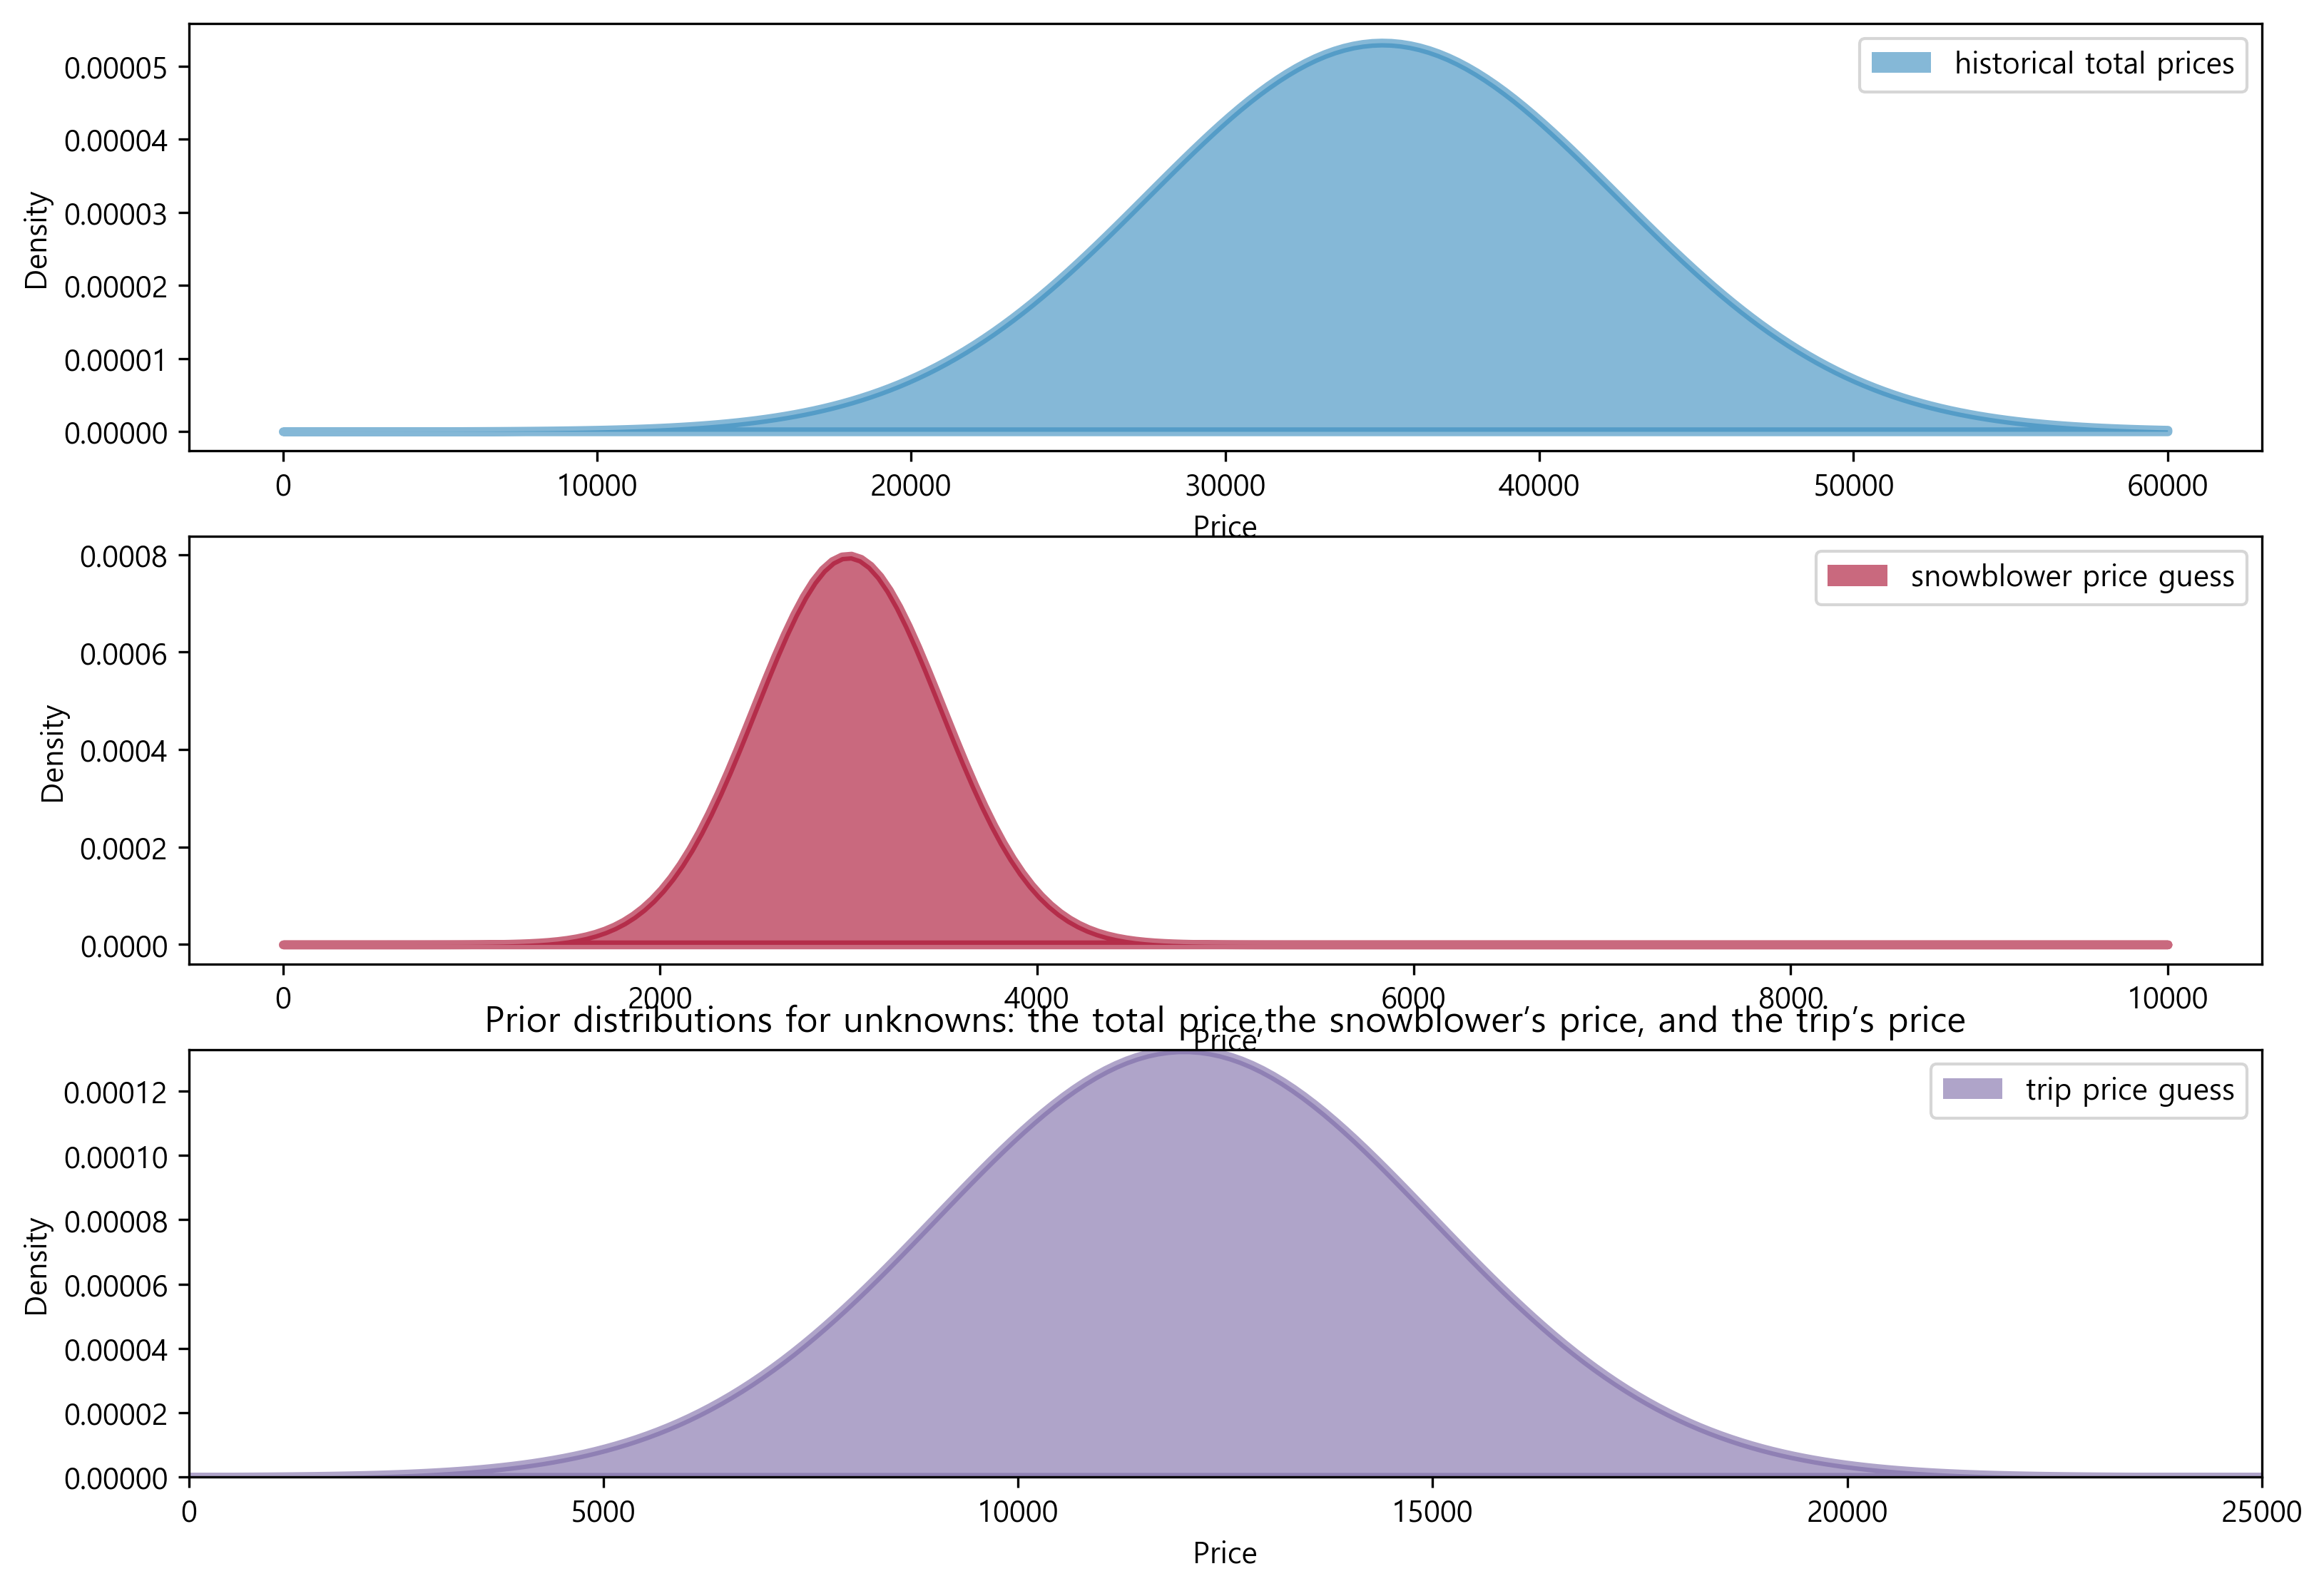

In [45]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Malgun Gothic')  # 그림 한글 폰트 지정, 맑은 고딕
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
figsize(12.5, 9)
norm_pdf = stats.norm.pdf


# Density 그리기
# historical price
plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),color="#348ABD", lw=3, alpha=0.6,
label="historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])
plt.xlabel("Price");
plt.ylabel("Density")

#제설기
plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
color="#A60628", lw=3, alpha=0.6,
label="snowblower price guess")
p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])
plt.xlabel("Price");
plt.ylabel("Density")

#토론토
plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x , 0, norm_pdf( x, 12000, 3000),color="#7A68A6", lw=3, alpha=0.6,
label="trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.title("Prior distributions for unknowns: the total price,\
the snowblower’s price, and the trip’s price")
plt.legend([p3], [sp3.get_label()]);
plt.xlabel("Price");
plt.ylabel("Density")

 [-----------------100%-----------------] 50000 of 50000 complete in 3.7 sec
 19866.724753360904 13435320.571478758


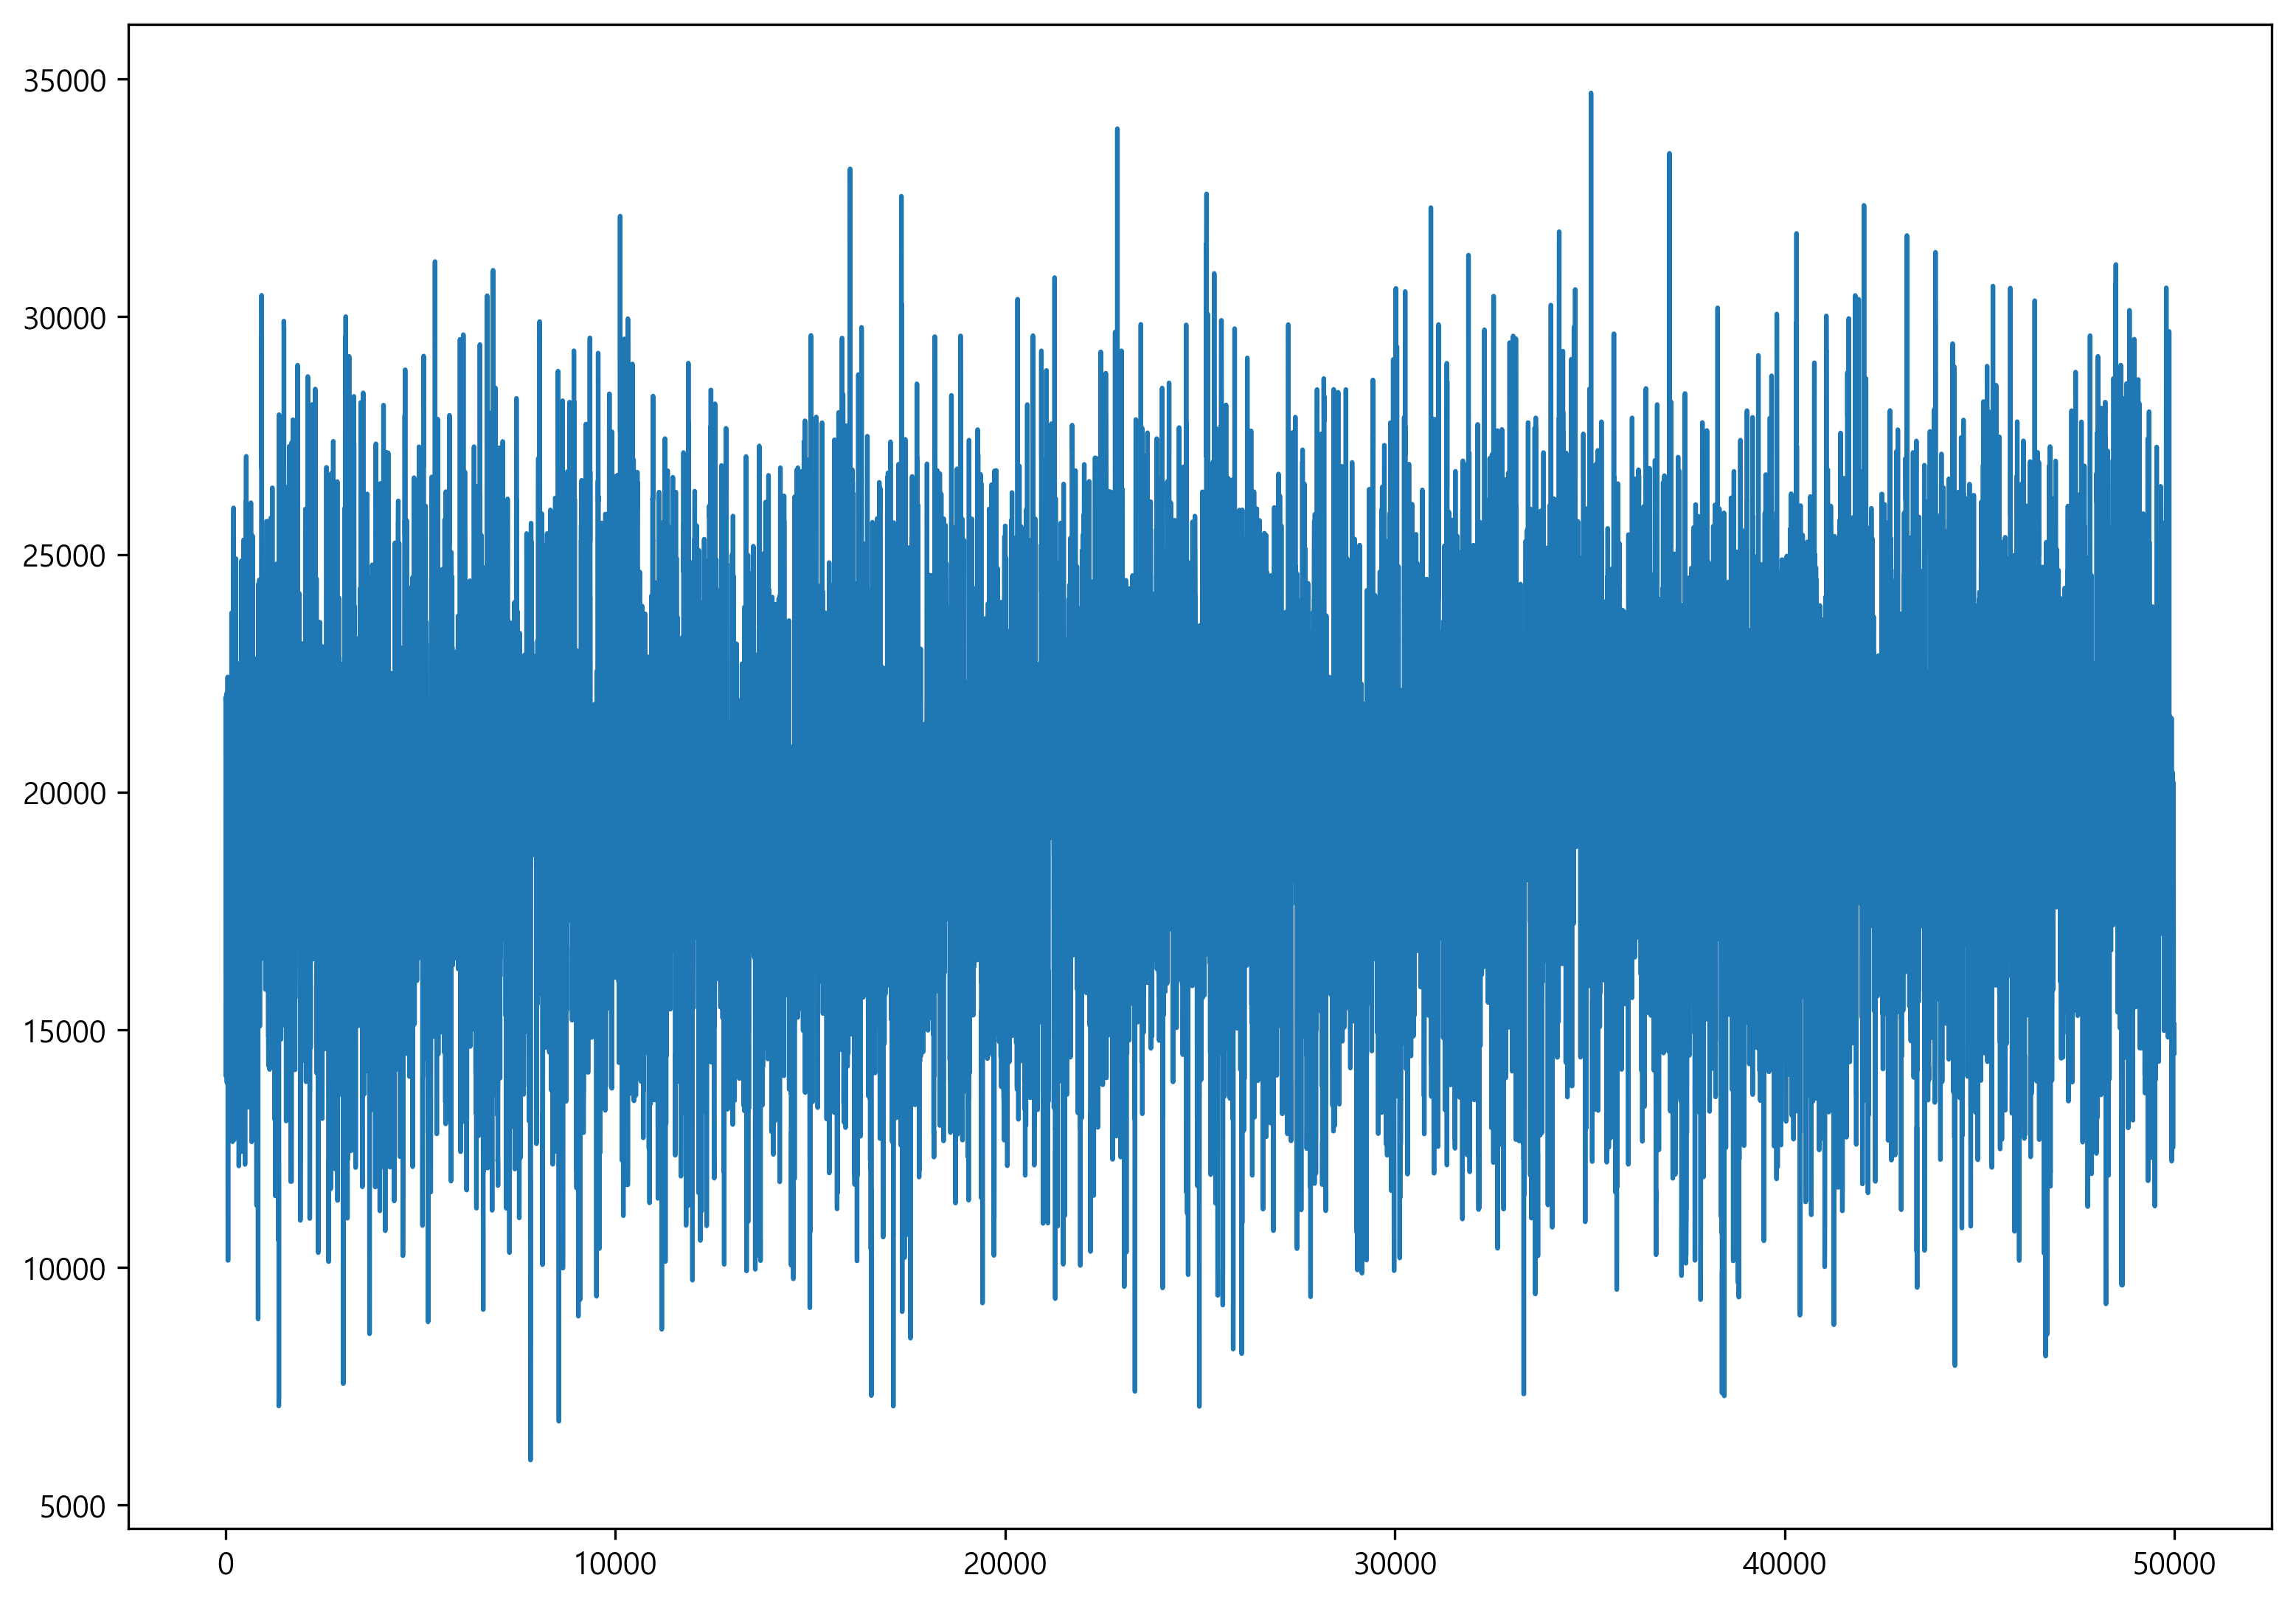

In [46]:
import pymc as pm
from pymc.Matplot import plot as mcplot
data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]
mu_prior = 35e3
std_prior = 75e2
true_price = pm.Normal("true_price", mu_prior, 1.0 / std_prior ** 2)
prize_1 = pm.Normal("first_prize", data_mu[0], 1.0 / data_std[0] ** 2)
prize_2 = pm.Normal("second_prize", data_mu[1], 1.0 / data_std[1] ** 2)
price_estimate = prize_1 + prize_2
@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
    return pm.normal_like(true_price, price_estimate, 1 / (3e3) ** 2)
mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(50000, 0)
price_trace = mcmc.trace("true_price")[:]

plt.plot(price_trace)
print("\n",price_trace.mean(),price_trace.var())

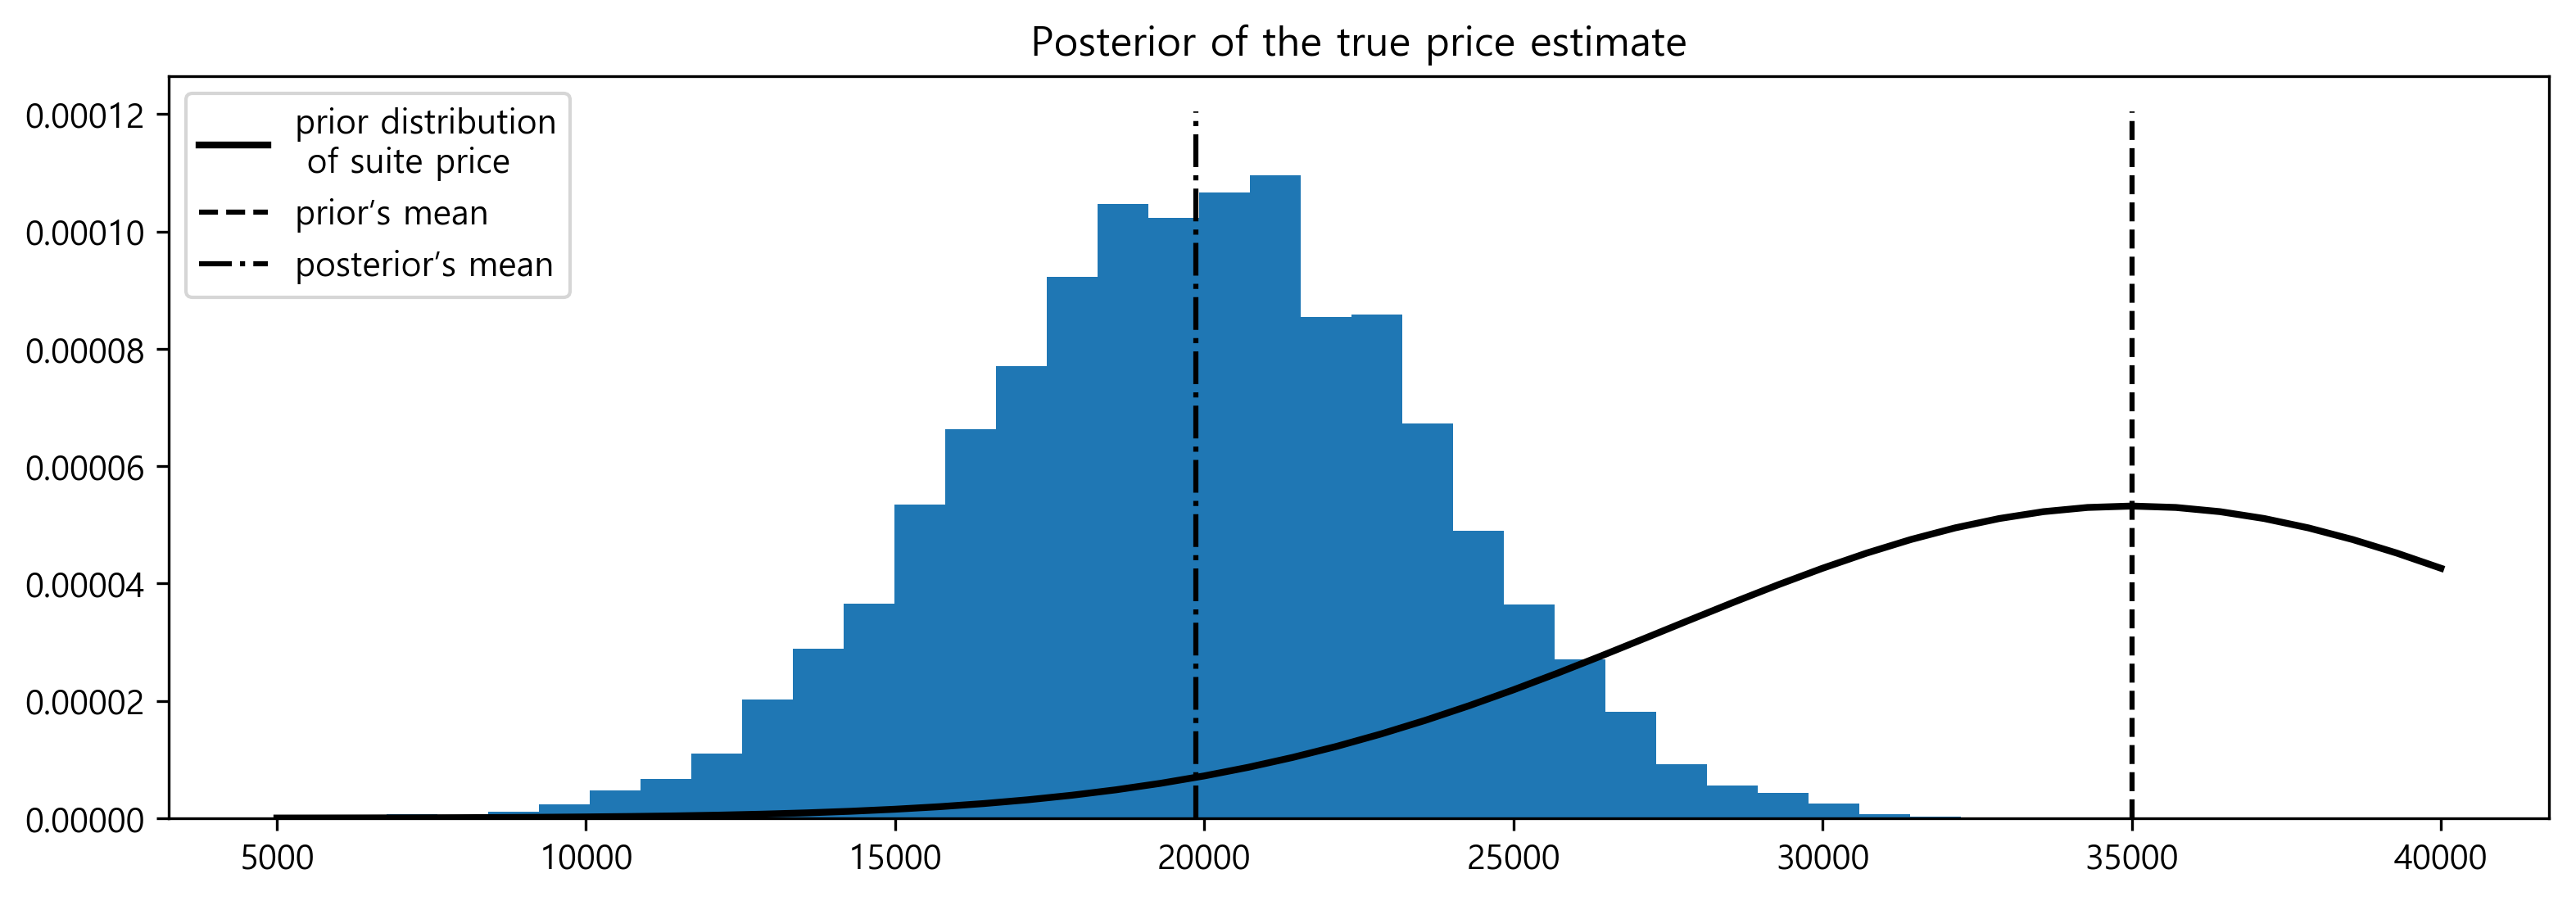

In [47]:
figsize(12.5, 4)
import scipy.stats as stats
# Plot the prior distribution.
x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2,
label="prior distribution\n of suite price")
# Plot the posterior distribution, represented by samples from the MCMC.
_hist = plt.hist(price_trace, bins=35, density=True, histtype="stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="prior’s mean",
linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), \
label="posterior’s mean", linestyles="-.")
plt.legend(loc="upper left");

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


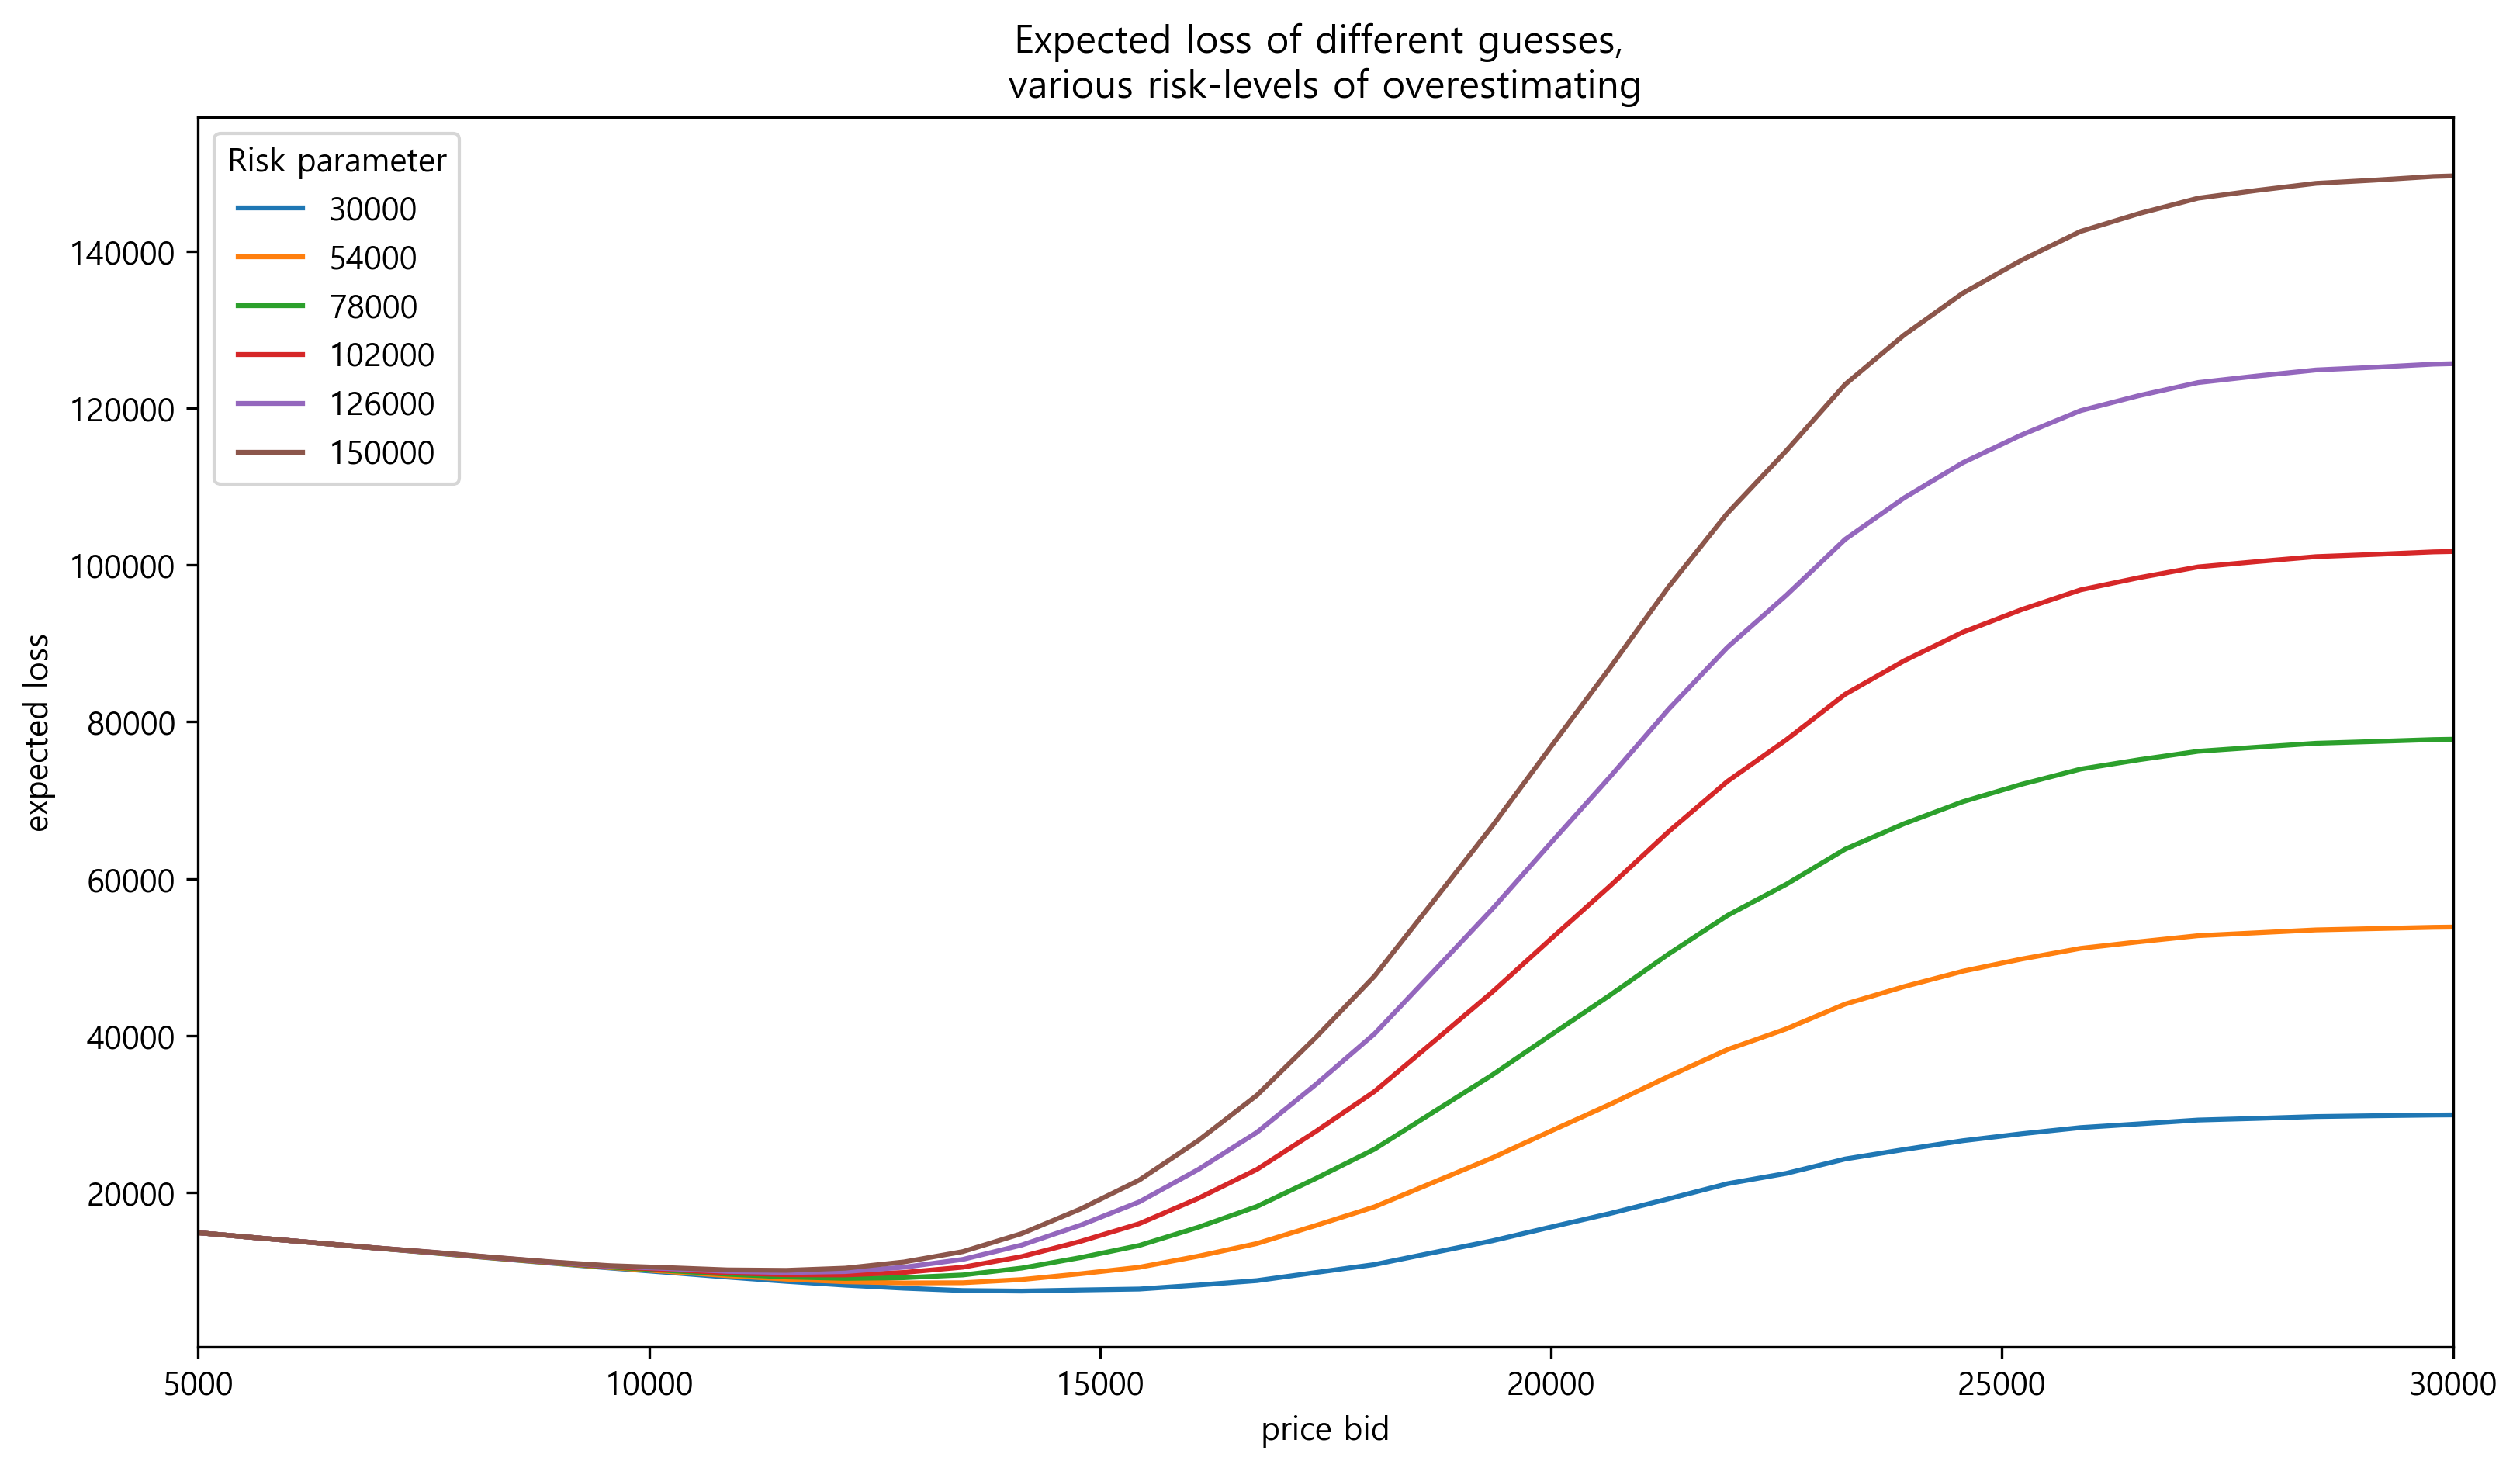

In [48]:
figsize(12.5, 7)
# numpy friendly showdown_loss

def showdown_loss(guess, true_price, risk=80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2 * true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)

plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


minimum at risk 30000: 14320.46
minimum at risk 54000: 13081.21
minimum at risk 78000: 12526.14
minimum at risk 102000: 11625.18
minimum at risk 126000: 11625.18
minimum at risk 150000: 11625.18


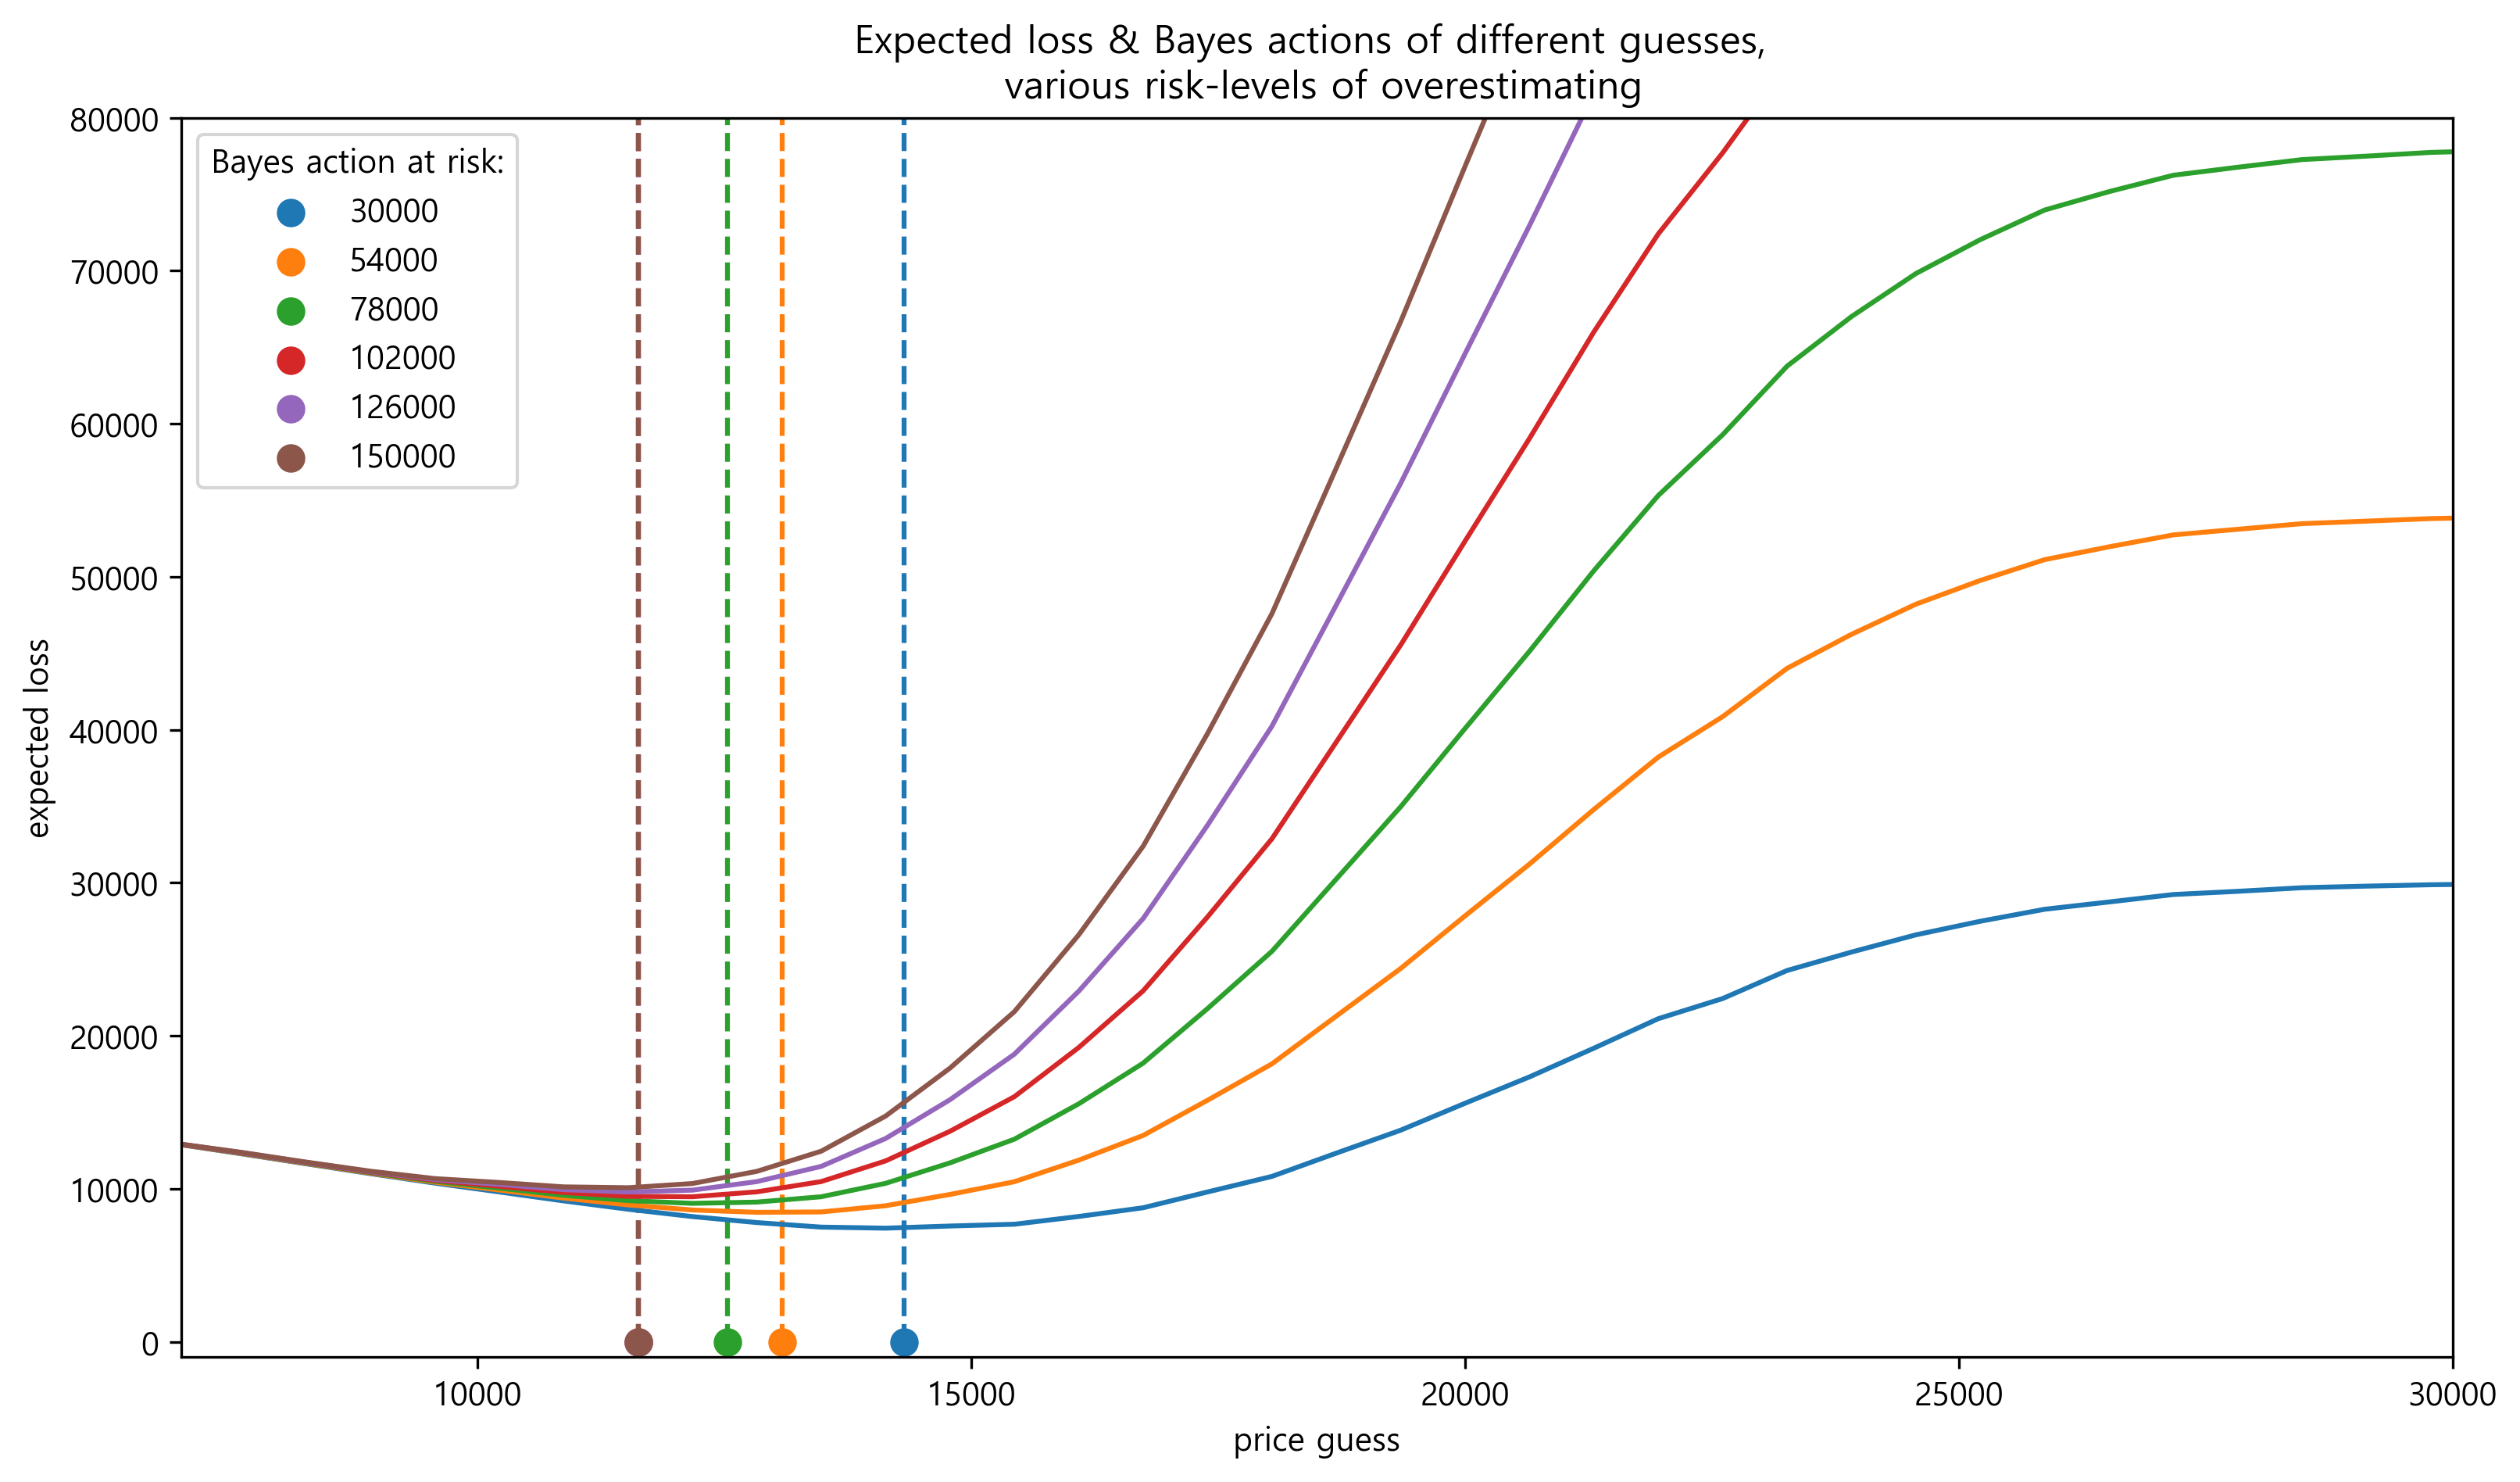

In [49]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))

plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

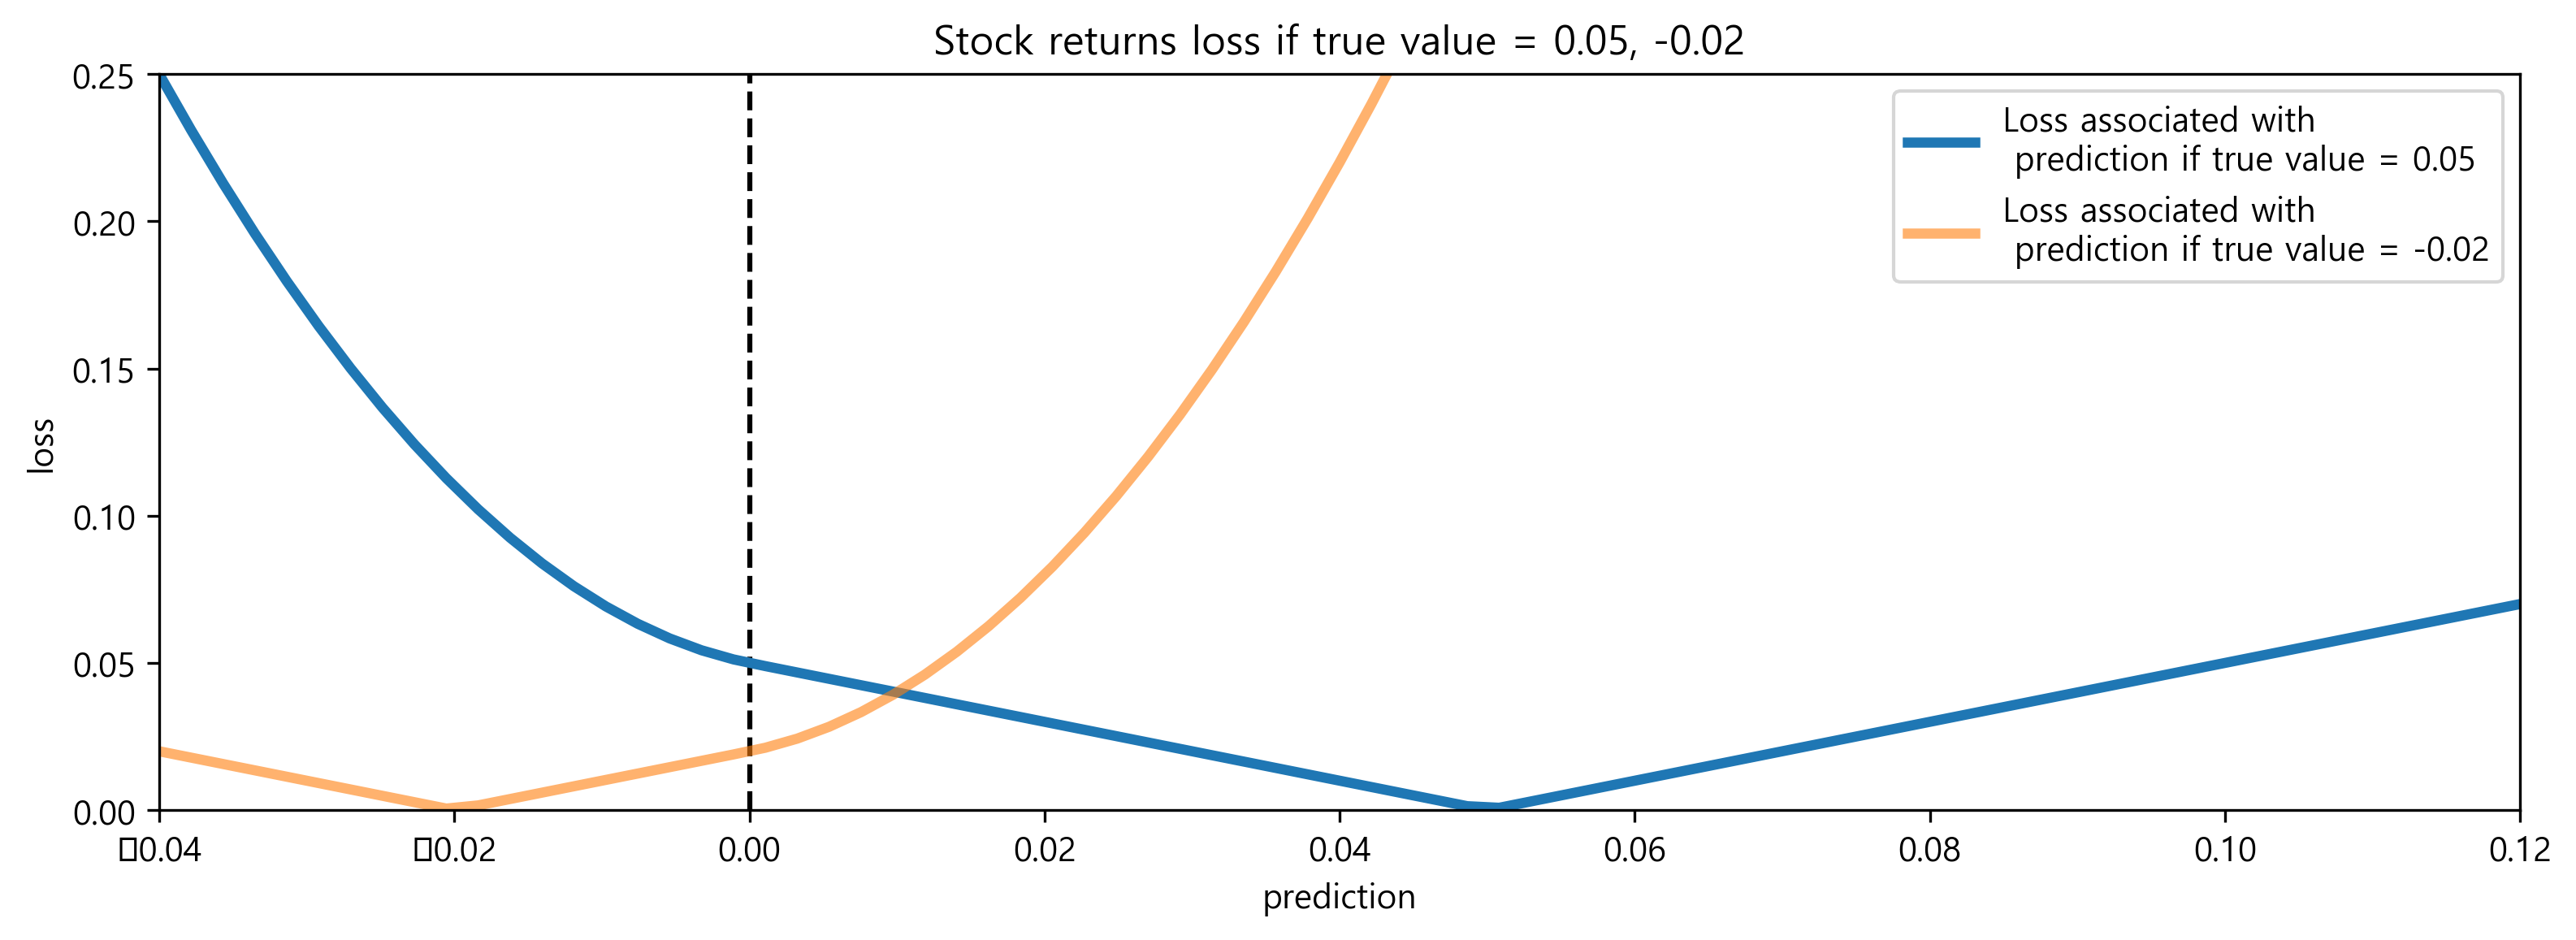

In [50]:
figsize(12.5, 4)

# 금융 손실함수 정의
def stock_loss(true_return, yhat, alpha=100.):
    if true_return * yhat < 0:
        # opposite signs, not good
        return alpha * yhat ** 2 - np.sign(true_return) * yhat \
            + abs(true_return)
    else:
        return abs(true_return - yhat)


true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred],
         label="Loss associated with\n prediction if true value = 0.05", lw=3)
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha=0.6,
         label="Loss associated with\n prediction if true value = -0.02", lw=3)
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

0.49731657751340774 -0.0009807034311646924


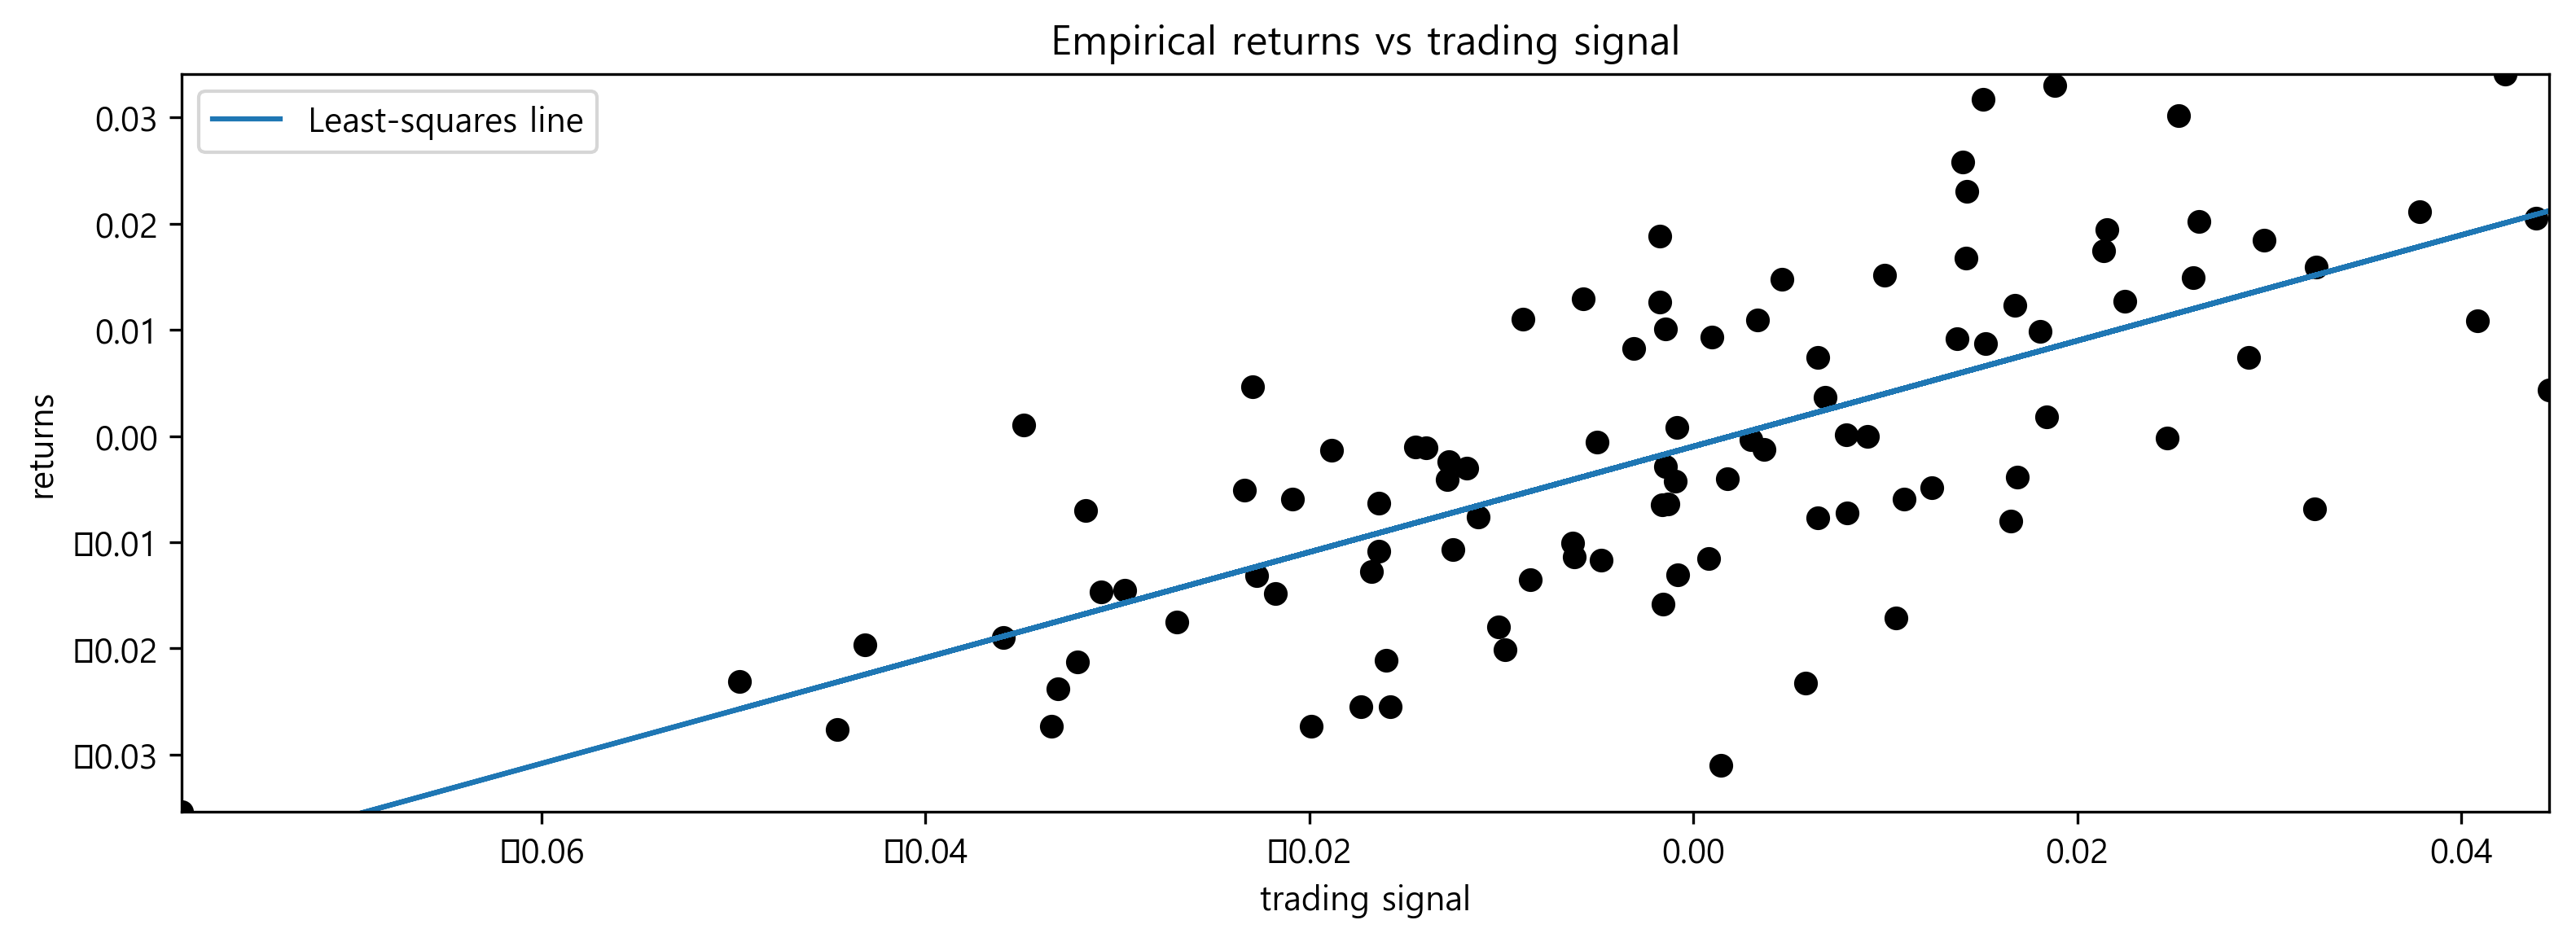

In [51]:
# Code to create artificial data
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

# 최소제곱법으로 계수 구하기
ls_coef_ = np.cov(X, Y)[0, 1] / np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

print(ls_coef_, ls_intercept)

# scatter plot과 회귀 직선
plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

 [-----------------100%-----------------] 100000 of 100000 complete in 7.6 secPlotting alpha
Plotting beta
Plotting prec

 -0.000985140507064825 0.49235980904260884


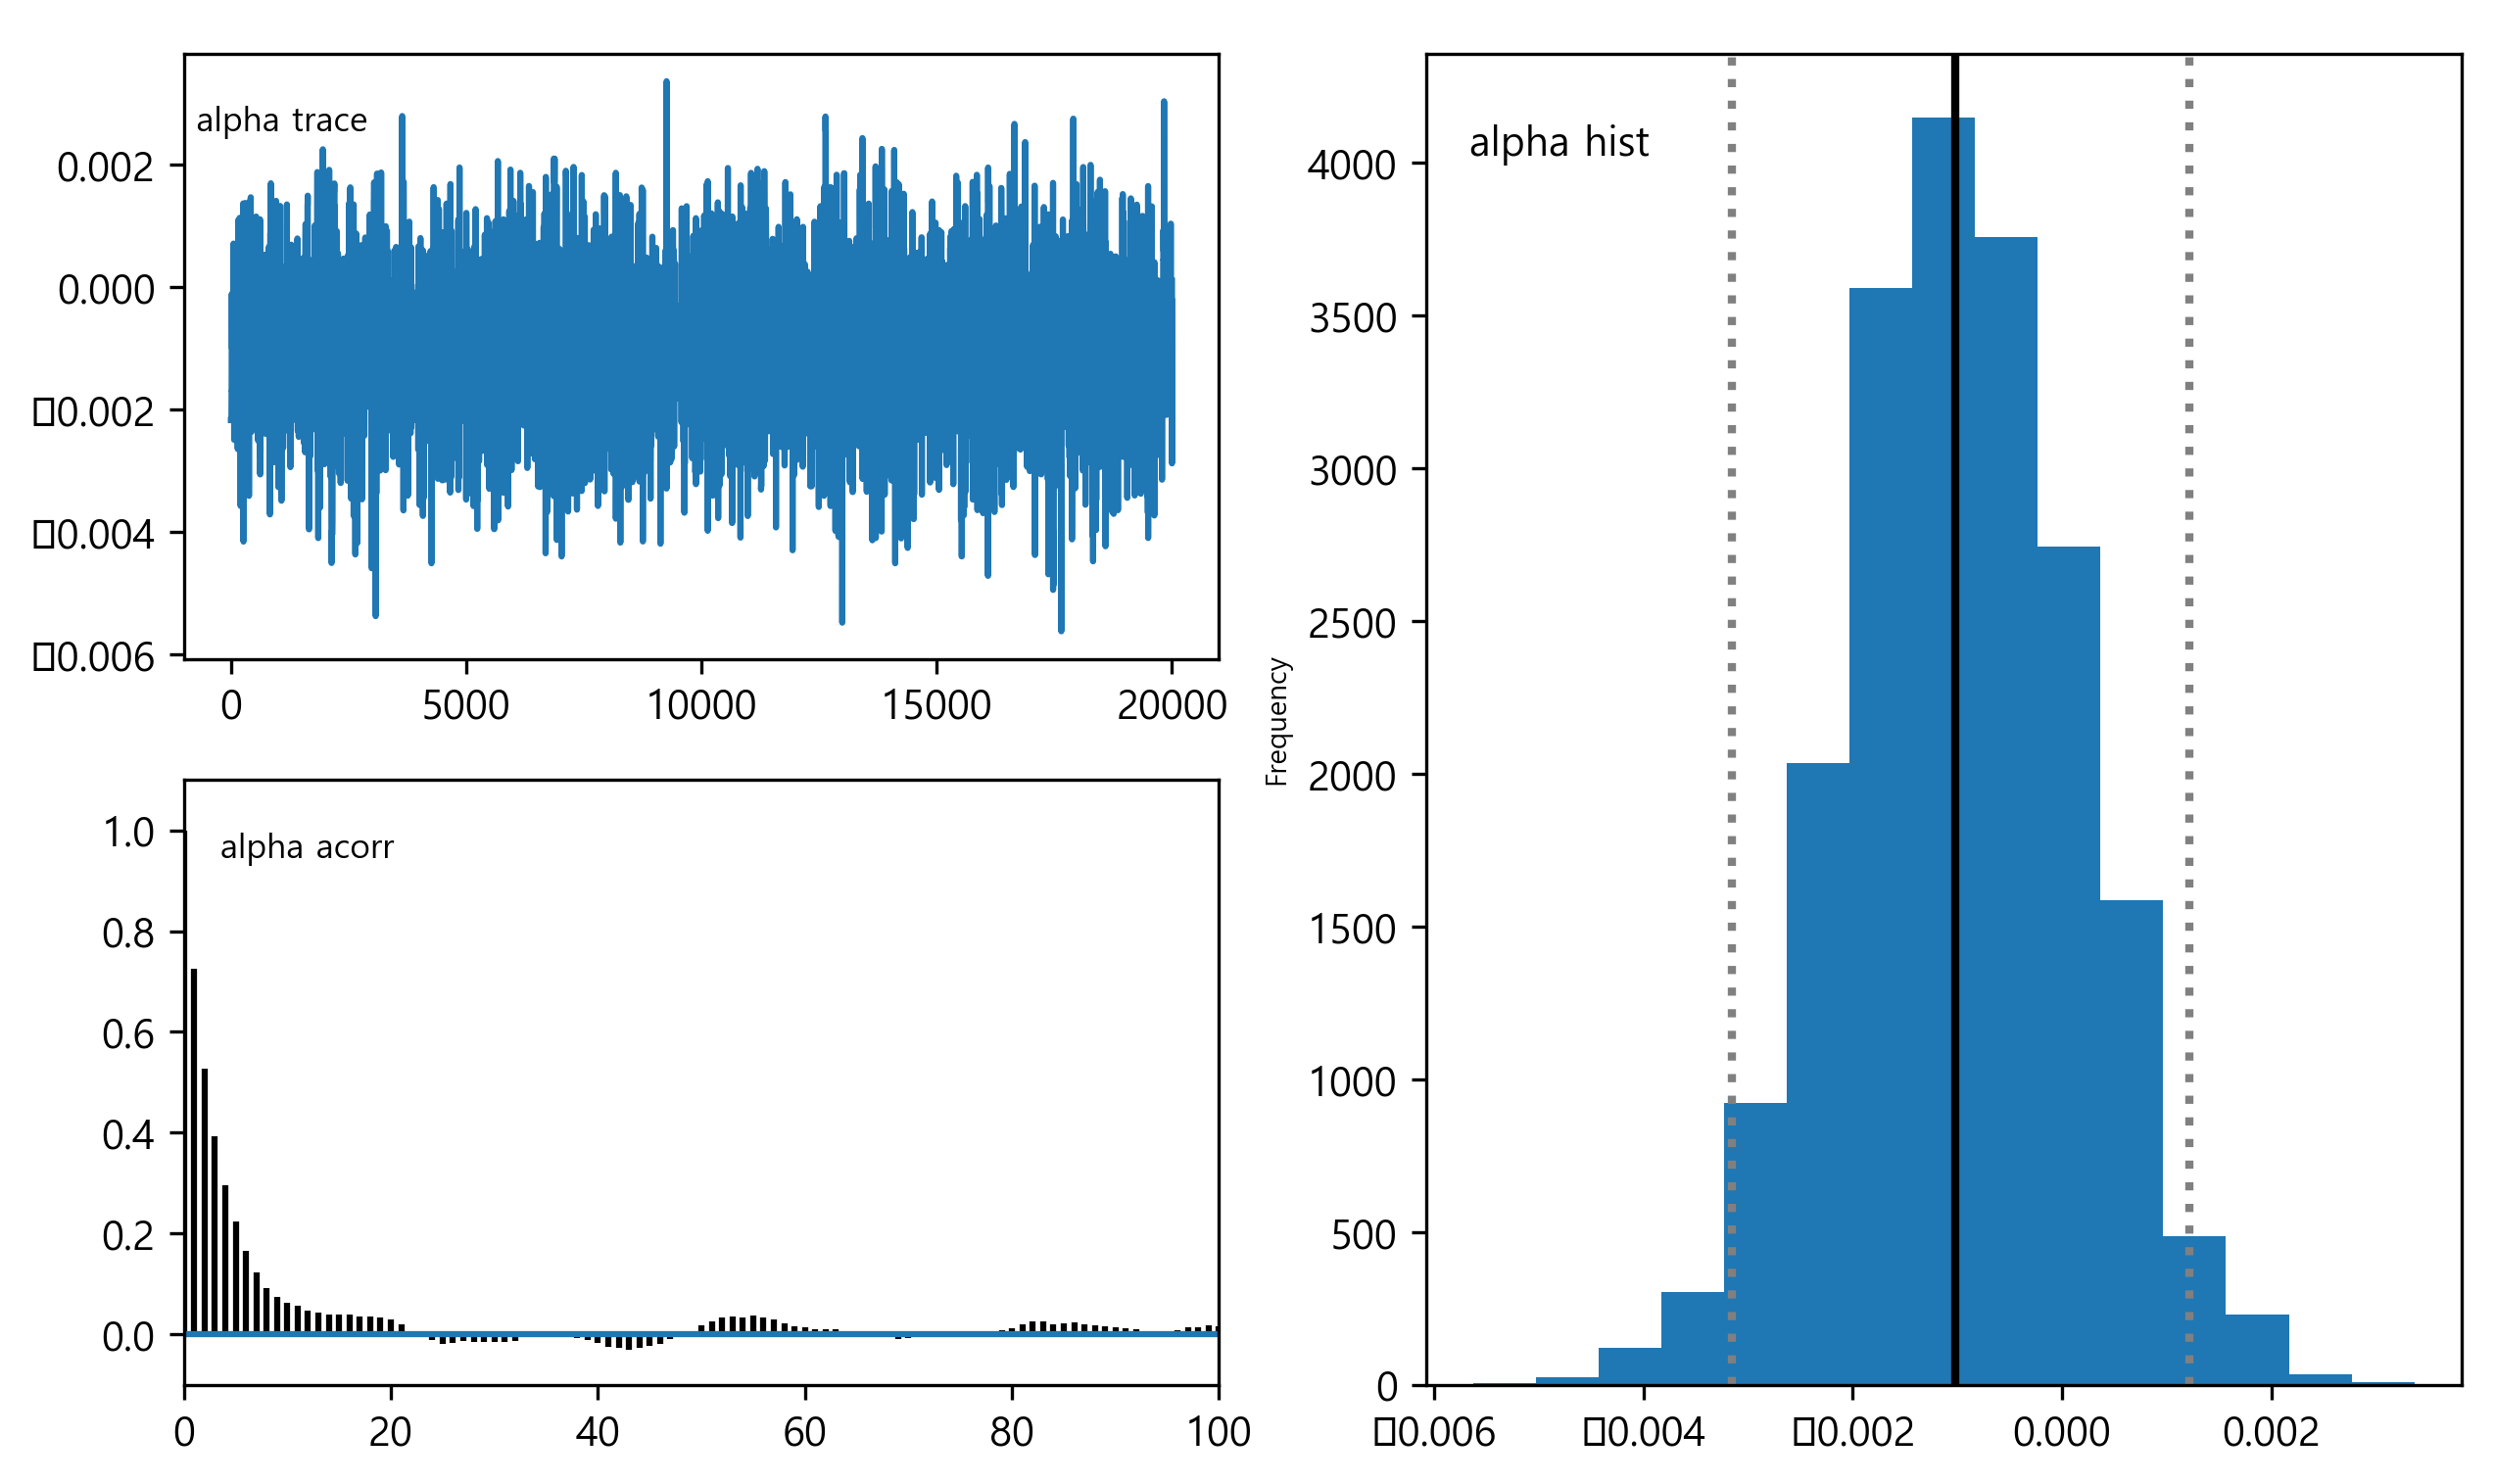

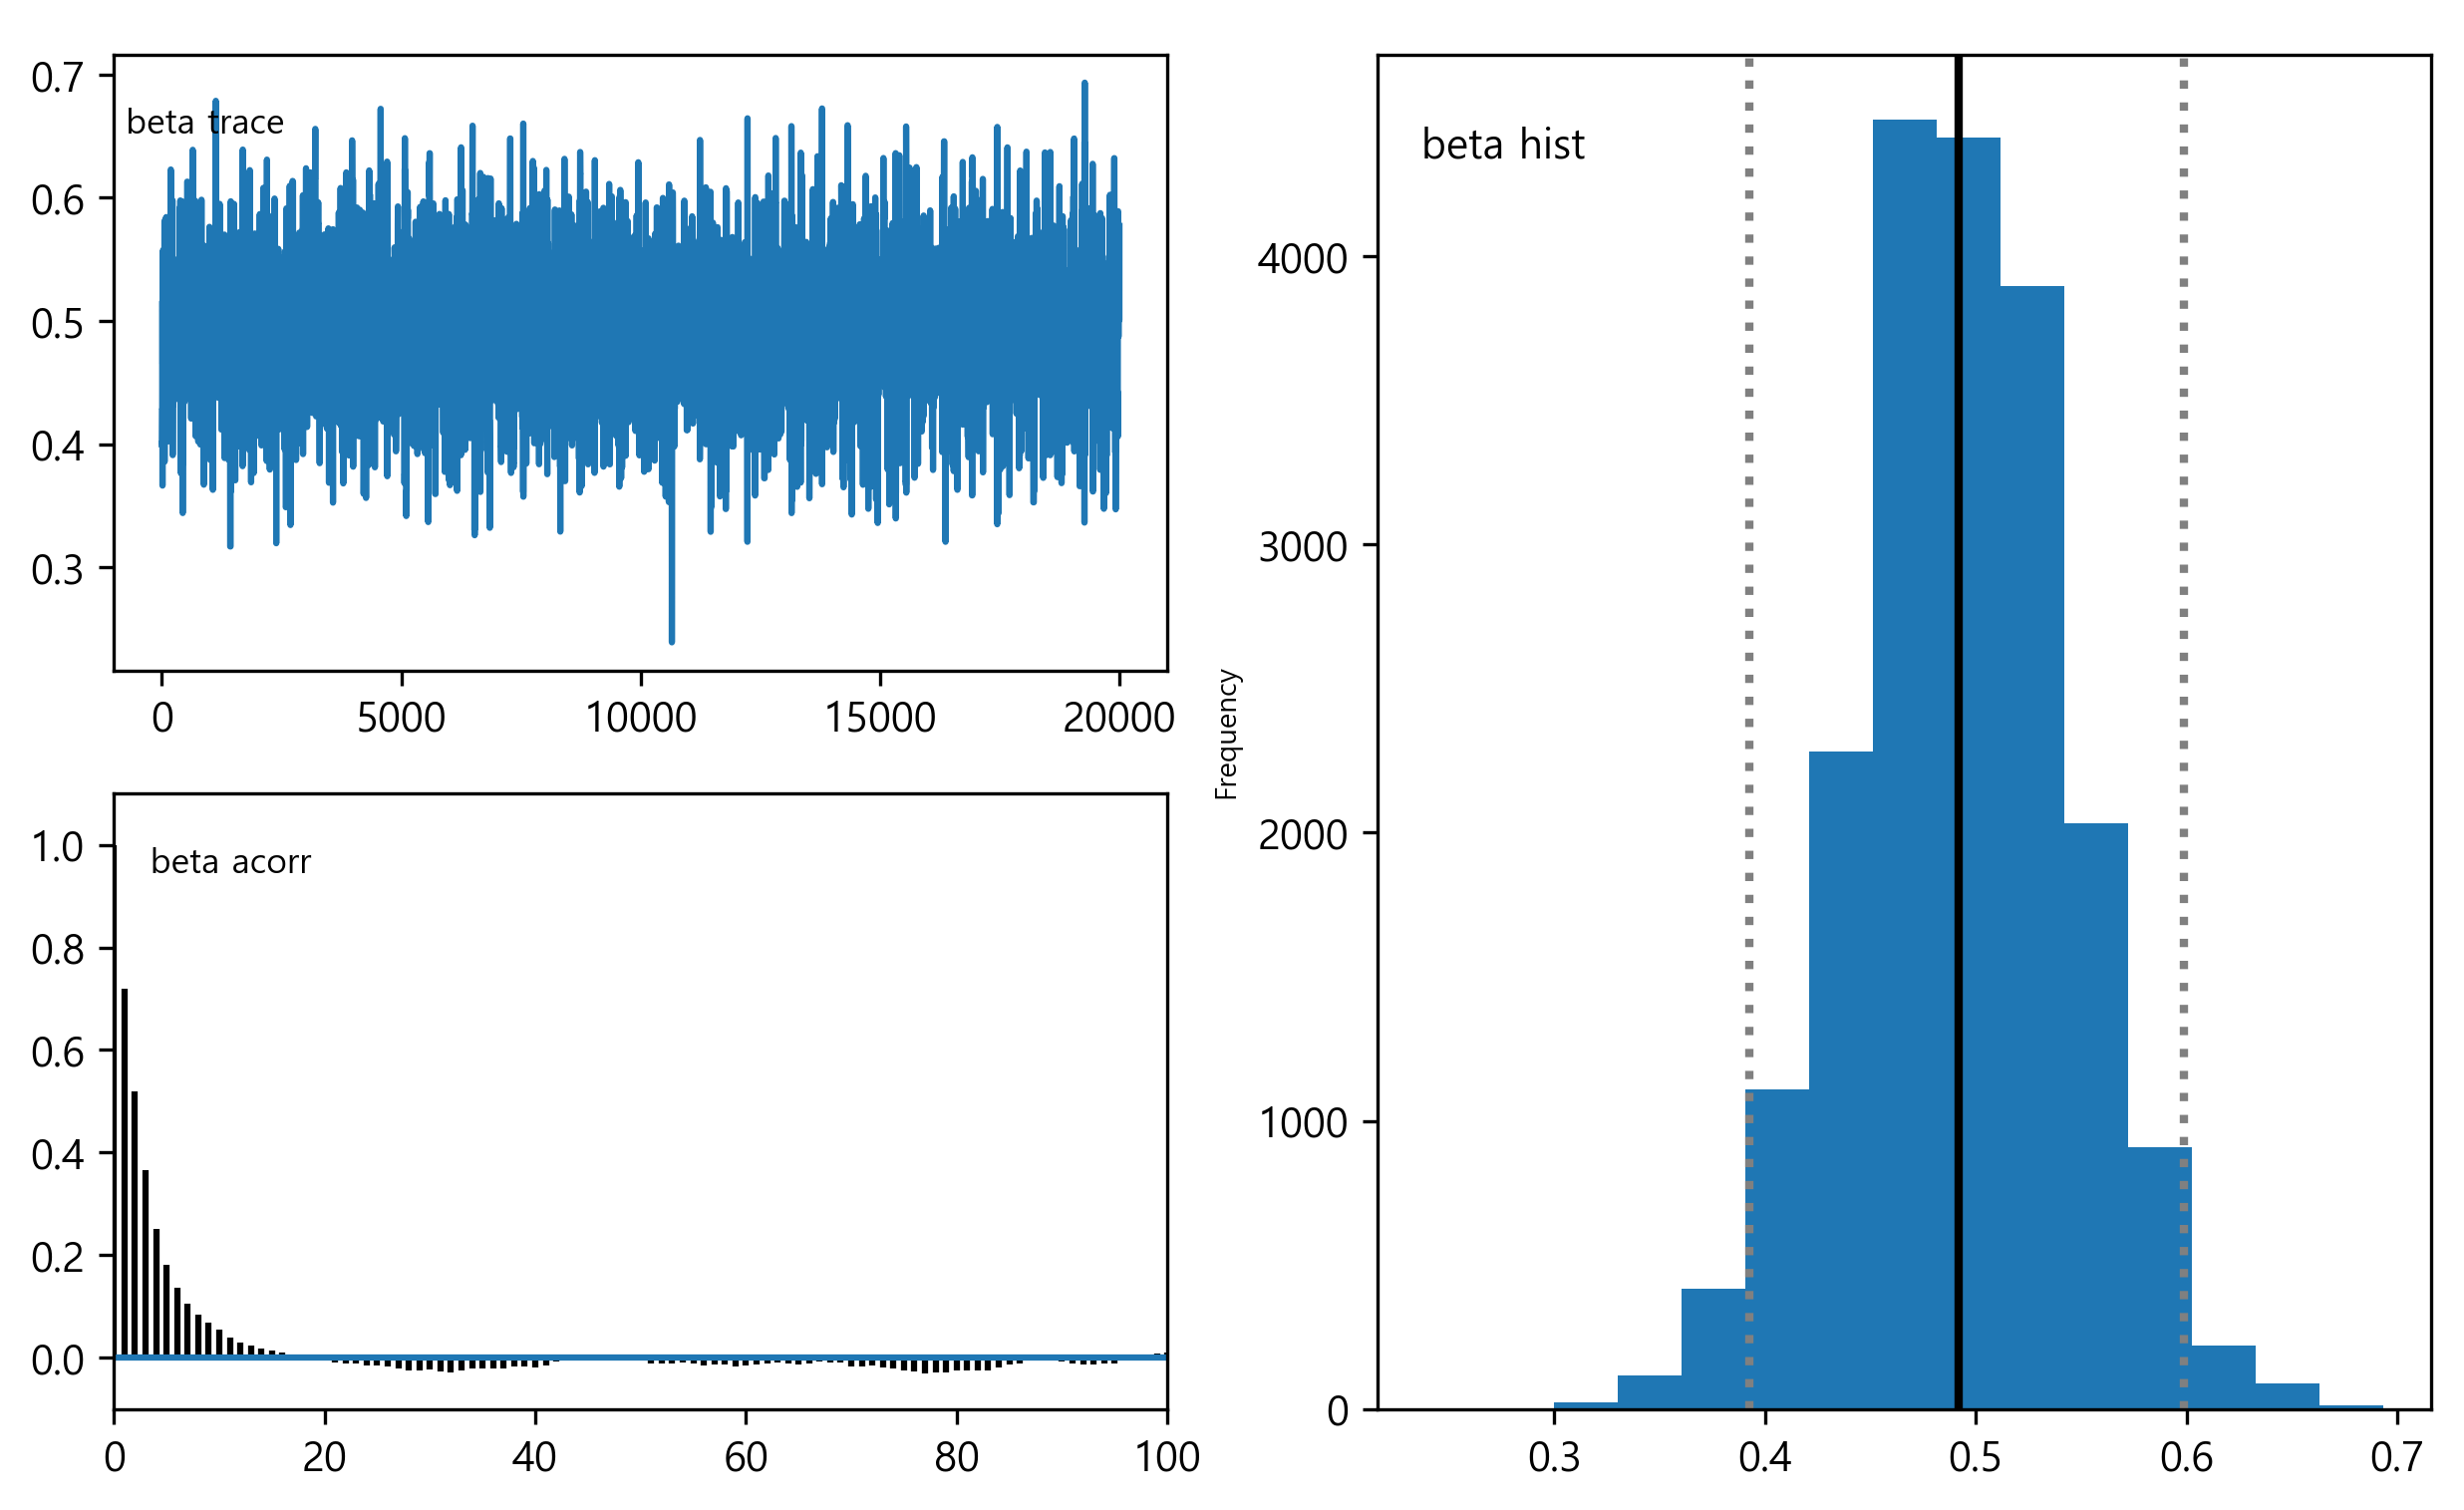

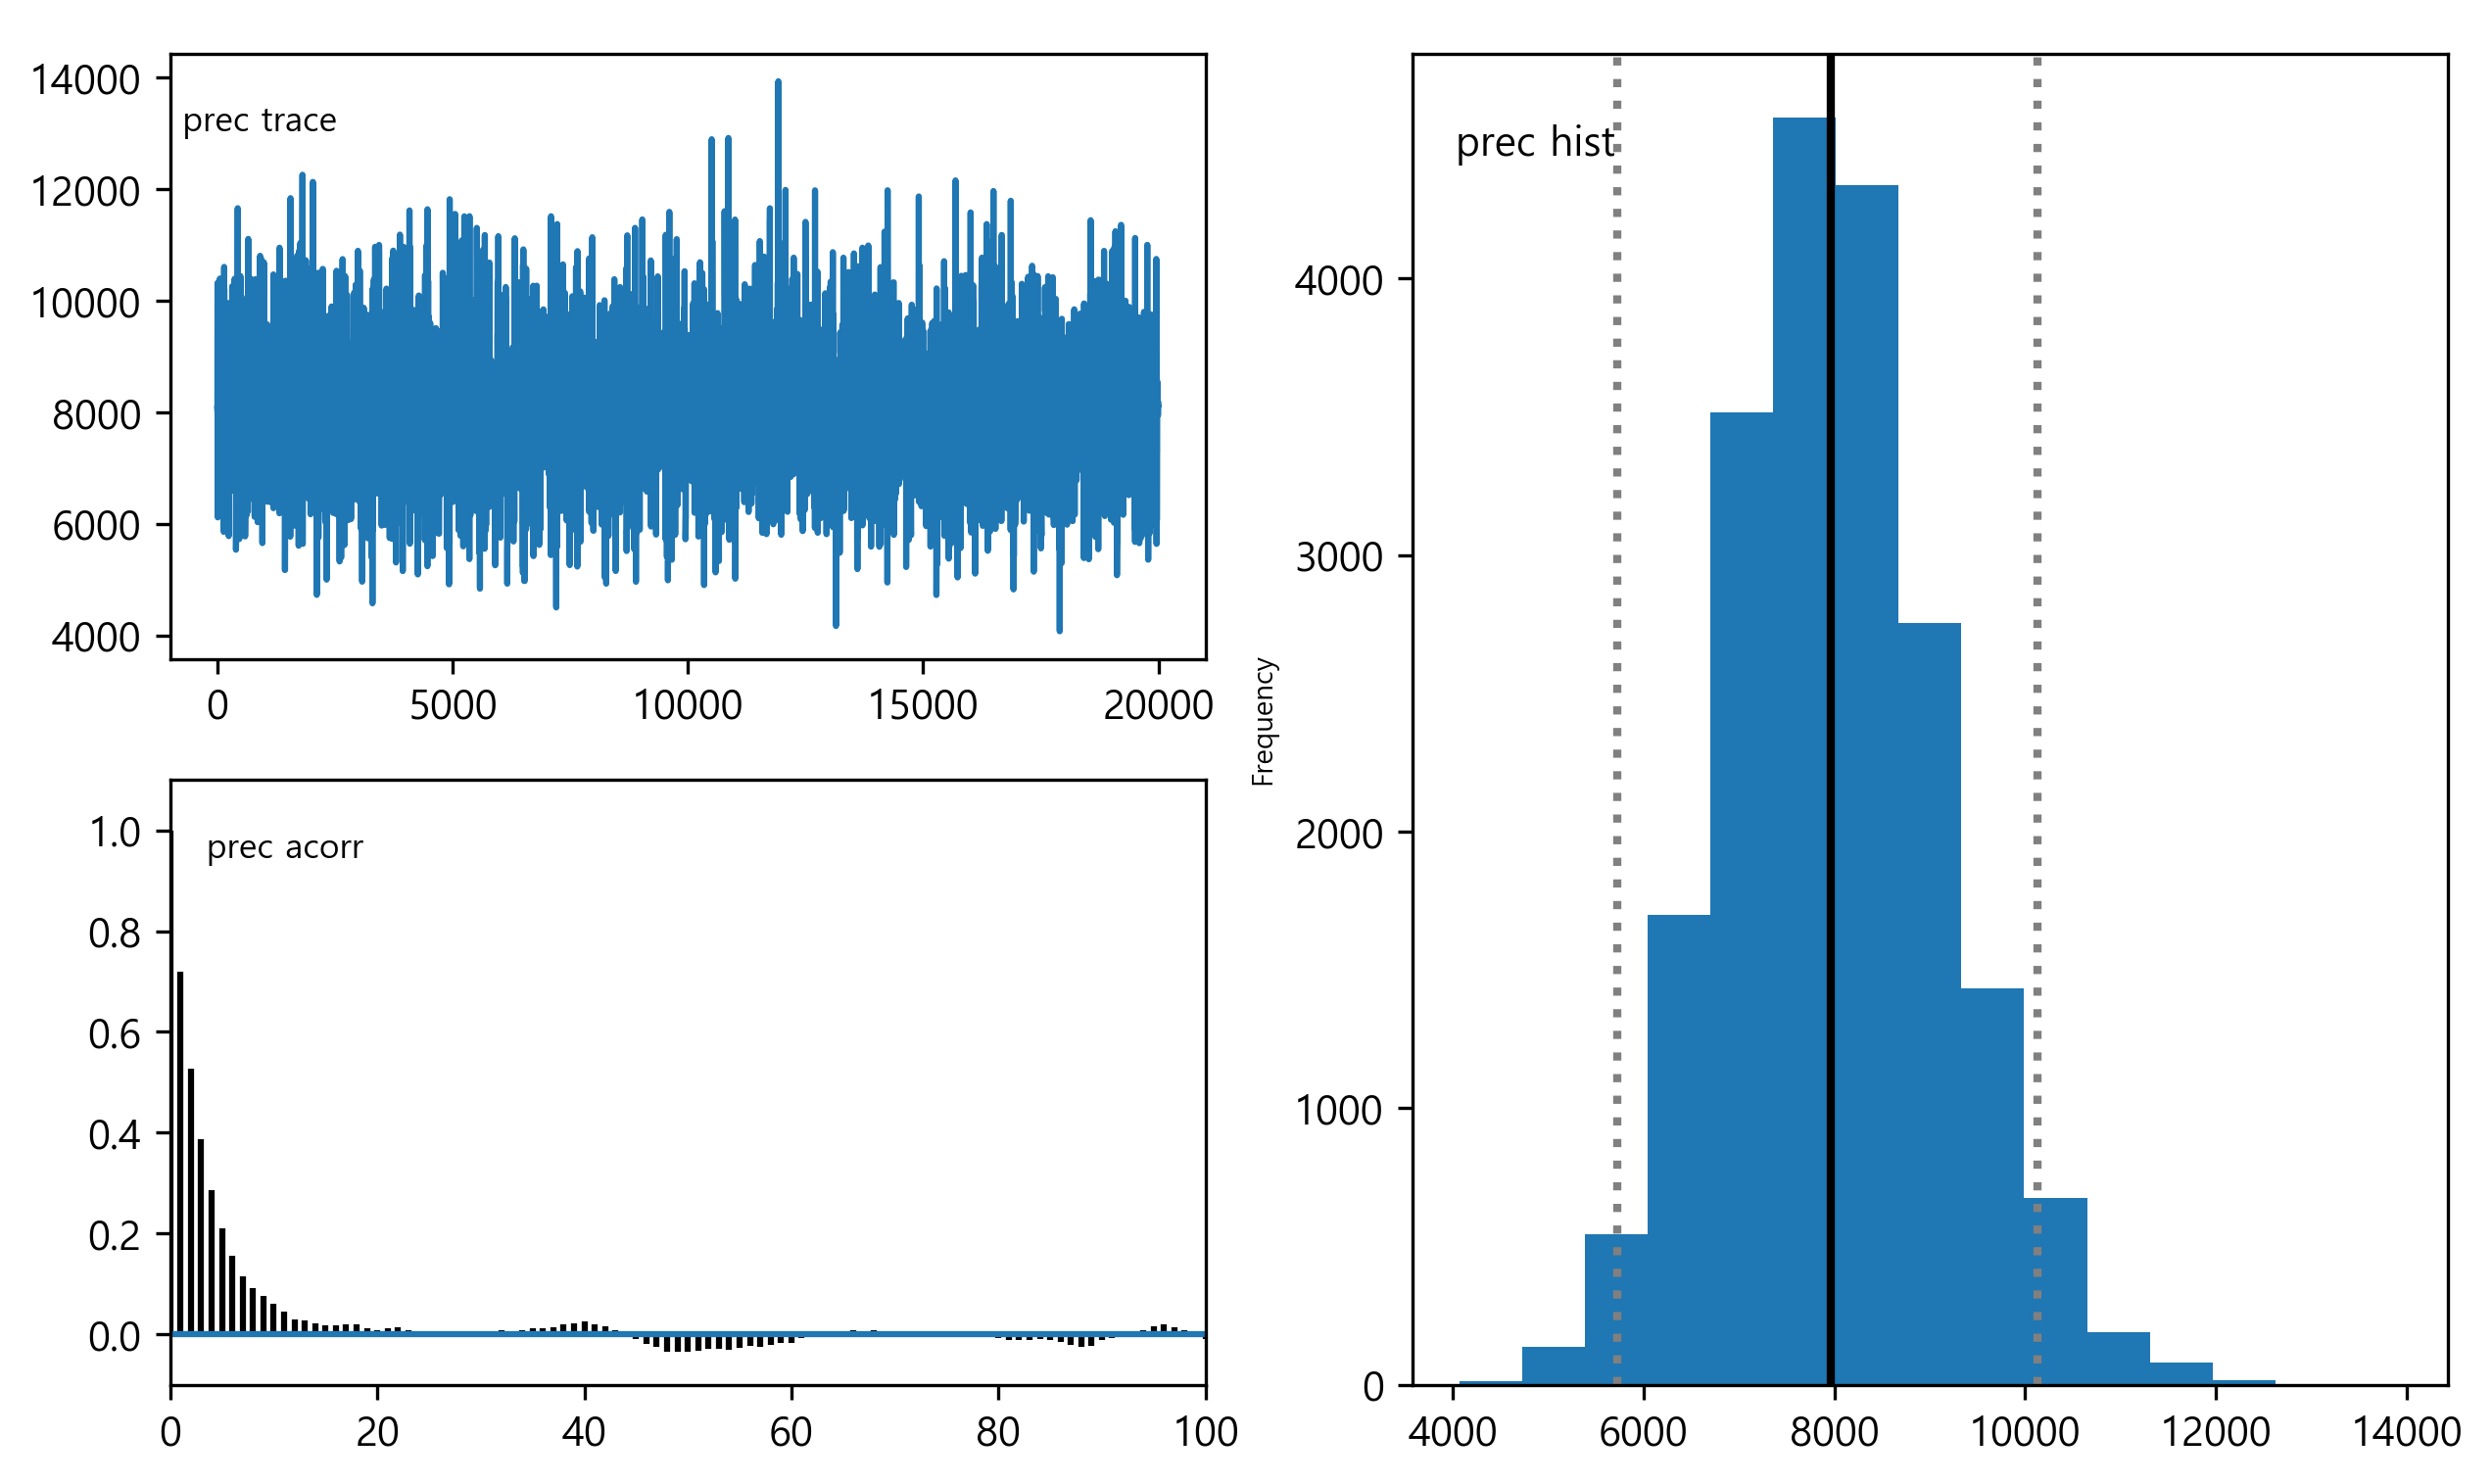

In [52]:
import pymc as pm
from pymc.Matplot import plot as mcplot

std = pm.Uniform("std", 0, 100, trace=False)  # this needs to be explained.


@pm.deterministic
def prec(U=std):
    return 1.0 / (U) ** 2

beta = pm.Normal("beta", 0, 0.0001) # 평균 0, 분산 100
alpha = pm.Normal("alpha", 0, 0.0001) # 평균 0, 분산 100


@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta * X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)
mcmc = pm.MCMC([alpha, beta, obs, std, prec])

mcmc.sample(100000, 80000)
mcplot(mcmc)

alpha_trace=mcmc.trace("alpha")[:]

beta_trace=mcmc.trace("beta")[:]
print("\n",alpha_trace.mean(), beta_trace.mean())

20000


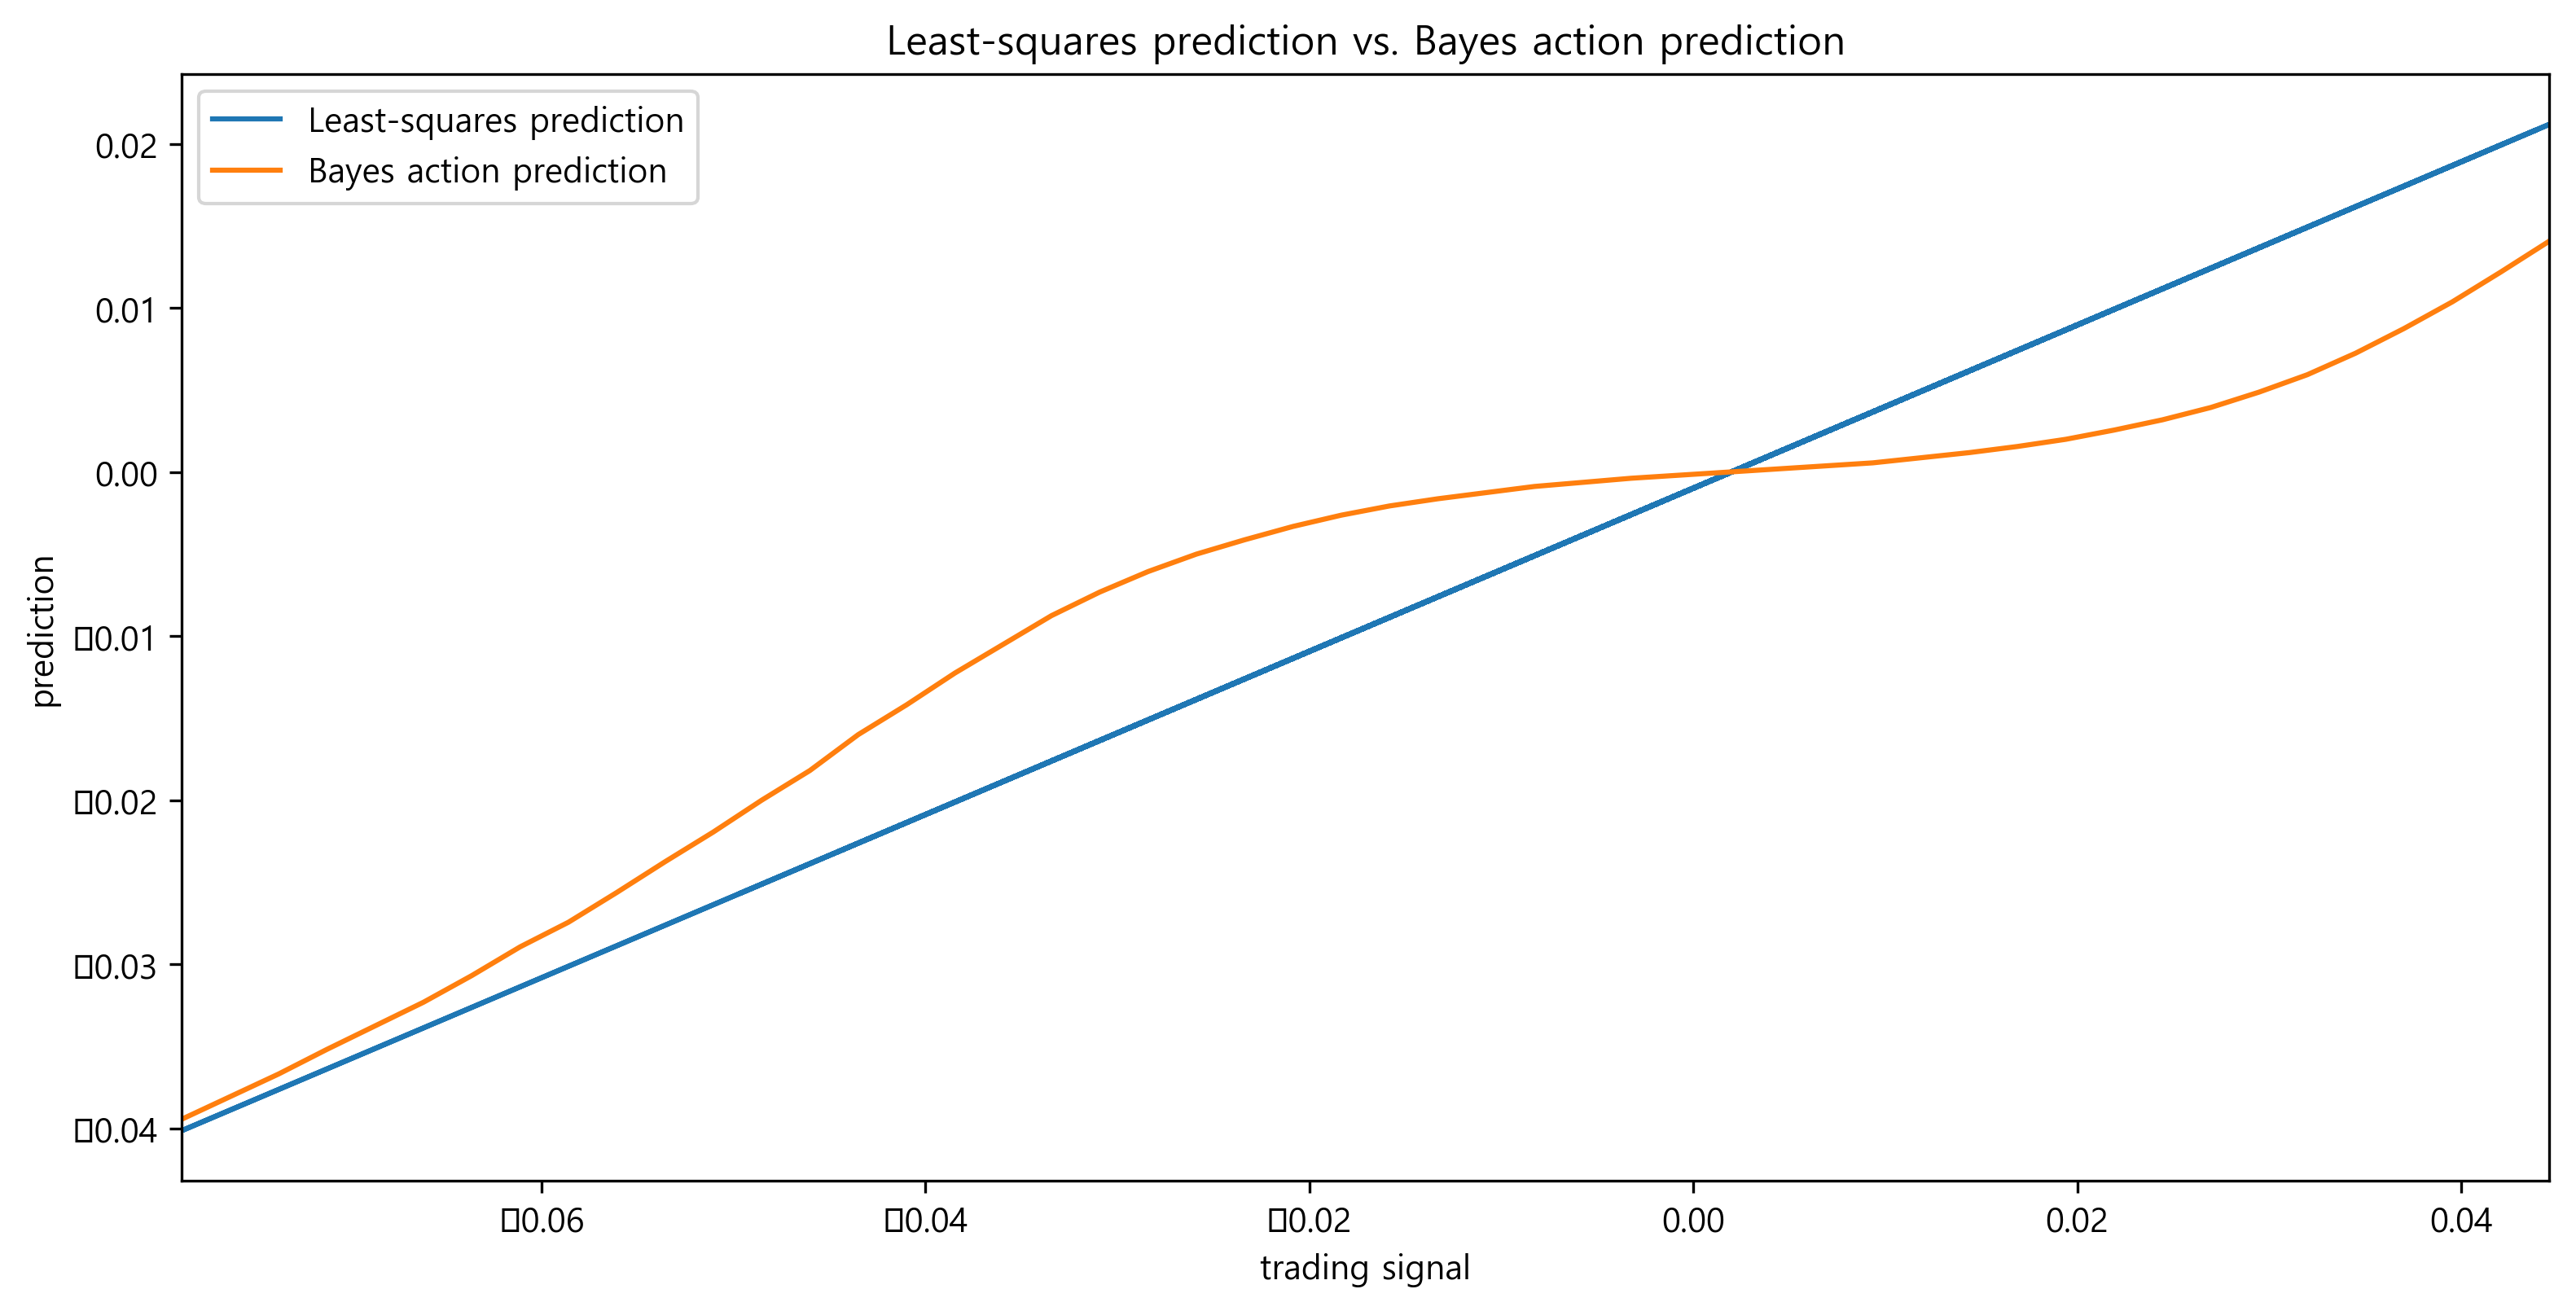

In [53]:
figsize(12.5, 6)
from scipy.optimize import fmin

# 주식 손실함수
def stock_loss(price, pred, coef=500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price * pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]
print(N)

noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples * signal \
    + noise


opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)


plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left");

In [37]:
from draw_sky2 import draw_sky

n_sky = 3  # choose a file/sky to examine.
data = np.genfromtxt(r"C:\Users\DataScienceLab1\Desktop\DarkWorlds\Train_Skies\Train_Skies\Training_Sky%d.csv" % (n_sky),
                      dtype=None,
                      skip_header=1,
                      delimiter=",",
                      usecols=[1, 2, 3, 4])
print("Data on galaxies in sky %d." % n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

ModuleNotFoundError: No module named 'draw_sky2'

In [12]:
def euclidean_distance(x, y):
    return np.sqrt(((x - y) **2).sum(axis=1))
def f_distance(gxy_pos, halo_pos, c):
# foo_position should be a 2D numpy array.
    return np.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:,None]
def tangential_distance(glxy_position, halo_position):
# foo_position should be a 2D numpy array.
    delta = glxy_position - halo_position
    t = (2*np.arctan(delta[:,1]/delta[:,0]))[:,None]
    return np.concatenate([-np.cos(t), -np.sin(t)], axis=1)
import pymc as pm
# Set the size of the halo’s mass.
mass_large = pm.Uniform("mass_large", 40, 180, trace=False)
# Set the initial prior position of the halos; it’s a 2D Uniform
# distribution.
halo_position = pm.Uniform("halo_position", 0, 4200, size=(1,2))
@pm.deterministic
def mean(mass=mass_large, h_pos=halo_position, glx_pos=data[:,:2]):
    return mass/f_distance(glx_pos, h_pos, 240)*\
    tangential_distance(glx_pos, h_pos)
ellpty = pm.Normal("ellipticity", mean, 1./0.05, observed=True,
value=data[:,2:] )
mcmc = pm.MCMC([ellpty, mean, halo_position, mass_large])
map_ = pm.MAP([ellpty, mean, halo_position, mass_large])
map_.fit()
mcmc.sample(200000, 140000, 3)

NameError: name 'data' is not defined

In [13]:
t = mcmc.trace("halo_position")[:].reshape( 20000,2)
fig = draw_sky(data)
plt.title("Galaxy positions and ellipticities of sky %d."%n_sky)
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.scatter(t[:,0], t[:,1], alpha=0.015, c="r")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

KeyError: 'halo_position'

In [14]:

halo_data = np.genfromtxt(r"C:\Users\wh\006775\Probabilistic-Programming-and-Bayesian-Methods-for-Hackers-master\Chapter5_LossFunctions\data\Training_halos.csv",
                          delimiter=",",
                          usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                          skip_header=1)
print(halo_data[n_sky])

OSError: C:\Users\wh\006775\Probabilistic-Programming-and-Bayesian-Methods-for-Hackers-master\Chapter5_LossFunctions\data\Training_halos.csv not found.

In [15]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:, 0], t[:, 1], alpha=0.015, c="r")
plt.scatter(halo_data[n_sky - 1][3], halo_data[n_sky - 1][4],
            label="True halo position",
            c="k", s=70)
plt.legend(scatterpoints=1, loc="lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

NameError: name 'draw_sky' is not defined

In [16]:

mean_posterior = t.mean(axis=0).reshape(1, 2)
print(mean_posterior)

NameError: name 't' is not defined

In [17]:

from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky - 1]

nhalo_all = _halo_data[0].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
sky_prediction = mean_posterior

print("한글Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all,
           x_ref_all, y_ref_all, sky_prediction)

print("\n")
# what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("한글Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all,
           x_ref_all, y_ref_all, random_guess)

ModuleNotFoundError: No module named 'DarkWorldsMetric'

In [18]:
from pymc.Matplot import plot as mcplot


def halo_posteriors(n_halos_in_sky, galaxy_data,
                    samples=5e5, burn_in=34e4, thin=4):
    # set the size of the halo's mass
    """
    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    @pm.deterministic
    def mass_large(exp_mass_large = exp_mass_large):
        return np.log(exp_mass_large)
    """

    mass_large = pm.Uniform("mass_large", 40, 180)

    mass_small_1 = 20
    mass_small_2 = 20

    masses = np.array([mass_large, mass_small_1, mass_small_2], dtype=object)

    # set the initial prior positions of the halos, it's a 2-d Uniform dist.
    halo_positions = pm.Uniform("halo_positions", 0, 4200,
                                size=(n_halos_in_sky, 2))  # notice this size

    fdist_constants = np.array([240, 70, 70])

    @pm.deterministic
    def mean(mass=masses, h_pos=halo_positions, glx_pos=data[:, :2],
             n_halos_in_sky=n_halos_in_sky):

        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += mass[i] / f_distance(glx_pos, h_pos[i, :], fdist_constants[i]) *\
                tangential_distance(glx_pos, h_pos[i, :])

        return _sum

    ellpty = pm.Normal("ellipcity", mean, 1. / 0.05, observed=True,
                       value=data[:, 2:])

    map_ = pm.MAP([ellpty, mean, halo_positions, mass_large])
    map_.fit(method="fmin_powell")

    mcmc = pm.MCMC([ellpty, mean, halo_positions, mass_large])
    mcmc.sample(samples, burn_in, thin)
    return mcmc.trace("halo_positions")[:]
n_sky = 215
data = np.genfromtxt(r"C:\Users\wh\006775\Probabilistic-Programming-and-Bayesian-Methods-for-Hackers-master\Chapter5_LossFunctions\data\Train_Skies\Train_Skies\Training_Sky%d.csv" % (n_sky),
                      dtype=None,
                      skip_header=1,
                      delimiter=",",
                      usecols=[1, 2, 3, 4])
# There are 3 halos in this file.
samples = 10.5e5
traces = halo_posteriors(3, data, samples=samples,
burn_in=9.5e5,
thin=10)

OSError: C:\Users\wh\006775\Probabilistic-Programming-and-Bayesian-Methods-for-Hackers-master\Chapter5_LossFunctions\data\Train_Skies\Train_Skies\Training_Sky215.csv not found.

In [19]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0], traces[:, i, 1], c=colors[i], alpha=0.02)


for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky - 1][3 + 2 * i], halo_data[n_sky - 1][4 + 2 * i],
                label="True halo position",
                c="k", s=90)

# plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

NameError: name 'draw_sky' is not defined

In [20]:
_halo_data = halo_data[n_sky - 1]
print(traces.shape)

mean_posterior = traces.mean(axis=0).reshape(1, 6)
print(mean_posterior)


nhalo_all = _halo_data[0].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
sky_prediction = mean_posterior


print("Using the mean:")
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, sky_prediction)

# what's a bad score?
print("\n")
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, random_guess)

NameError: name 'halo_data' is not defined